In [74]:
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [75]:
%reload_ext jupyternotify

<IPython.core.display.Javascript object>

# Part ② Machine Learning models

## Table of contents

- <a href='#0'>0. Importing python libraries and loading cleaned dataset</a>
- <a href='#1'>1. Feature engineering</a>
    - <a href='#1.1'>1.1 Scale of Energy and Emissions</a>
    - <a href='#1.2'>1.2 Input and targets definition</a>
- <a href='#2'>2. Regression function</a>
- <a href='#3'>3. Models for Energy</a>
    - <a href='#3.1'>3.1 Dummy regressor</a>
    - <a href='#3.2'>3.2 Linear regression</a>
    - <a href='#3.3'>3.3 Ridge regression</a>
    - <a href='#3.4'>3.4 Lasso regression</a>
    - <a href='#3.5'>3.5 SVM</a>
    - <a href='#3.6'>3.6 Random forest</a>
    - <a href='#3.7'>3.7 XGBoost</a>
- <a href='#4'>4. Baseline for Energy</a>
    - <a href='#4.1'>4.1 Models comparison</a>
    - <a href='#4.2'>4.2 XGBoost optimization</a>
    - <a href='#4.3'>4.3 XGBoost learning curves</a>
    - <a href='#4.4'>4.4 ENERGYSTARScore influence</a>
- <a href='#5'>5. Models for Emission</a>
    - <a href='#5.1'>5.1 Dummy regressor</a>
    - <a href='#5.2'>5.2 Linear regression</a>
    - <a href='#5.3'>5.3 Ridge regression</a>
    - <a href='#5.4'>5.4 Lasso regression</a>
    - <a href='#5.5'>5.5 SVM</a>
    - <a href='#5.6'>5.6 Random forest</a>
    - <a href='#5.7'>5.7 XGBoost</a>
- <a href='#6'>6. Baseline for Emissions</a>
    - <a href='#6.1'>6.1 Models comparison</a>
    - <a href='#6.2'>6.2 XGBoost optimization</a>
    - <a href='#6.3'>6.3 XGBoost learning curves</a>
    - <a href='#6.4'>6.4 ENERGYSTARScore influence</a>

# <a name="0">0. Importing python libraries and loading cleaned dataset</a>

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

import dataframe_image as dfi

In [77]:
# Jupyter settings
plt.rcdefaults()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# sns.set_theme()
sns.set_style("whitegrid")

In [78]:
df = pd.read_csv('cleaned.csv')

# <a name="1">1. Feature engineering</a>

## <a name="1.1">1.1 Scale of Energy and Emissions</a>

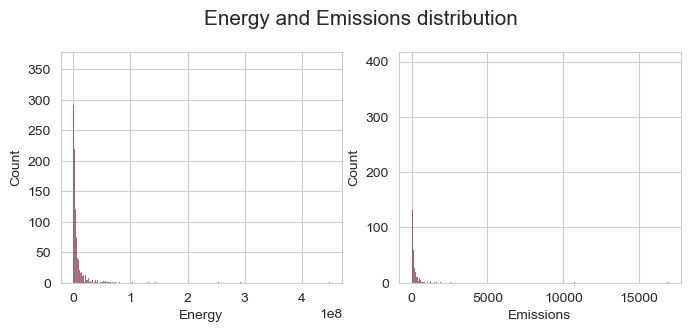

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(df['Energy'], ax=axes[0], color='#7B2E3E')
sns.histplot(df['Emissions'], ax=axes[1], color='#7B2E3E')

fig.suptitle('Energy and Emissions distribution', fontsize=15, y=1.02)
plt.savefig('energy_distribution', transparent=True, bbox_inches='tight')

plt.show()

<div class="alert alert-block alert-info">

Given the significant skewness in current distribution of target variables, it is interesting to transition to logarithm, so that it resembles more a normal distribution.
    
</div>

In [80]:
df['Energy'] = df['Energy'].apply(lambda x : np.log(x+1))
df['Emissions'] = df['Emissions'].apply(lambda x : np.log(x+1))

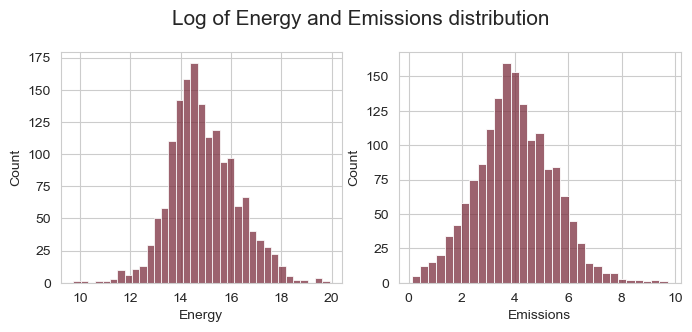

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(df['Energy'], ax=axes[0], color='#7B2E3E')
sns.histplot(df['Emissions'], ax=axes[1], color='#7B2E3E')

fig.suptitle('Log of Energy and Emissions distribution', fontsize=15, y=1.02)
plt.savefig('energy_distribution_log', transparent=True, bbox_inches='tight')

plt.show()

## <a name="1.2">1.2 Input and targets definition</a>

In [82]:
convert_dict = {'CouncilDistrictCode': object,
                'YearBuilt': object
               }
  
df = df.astype(convert_dict)

In [83]:
df.dtypes

OSEBuildingID            int64
PrimaryPropertyType     object
CouncilDistrictCode     object
Neighborhood            object
Latitude               float64
Longitude              float64
YearBuilt               object
NumberofBuildings       object
NumberofFloors         float64
PropertyGFATotal         int64
PropertyGFABuilding      int64
PropertyGFAParking       int64
ENERGYSTARScore        float64
Energy                 float64
Emissions              float64
TotalInnerSurface      float64
dtype: object

In [84]:
X = df.drop(['Energy', 'Emissions'], axis=1)

y_nrj = df['Energy']

y_emi = df['Emissions']

# <a name="2">2. Regression function</a> 

In [85]:
def regressor(X, y, model, params={}, see_inputs=False):
    
    '''
    Carries out preprocessing, and regression based on given model and parameters.
    Returns GridSearchCV results as a dataframe.
    Contains R2, MAE, RMSE of test.
    '''

    # Step 1 - Preprocessing numerical and categorical features
    
    ## 1.1 - KNN Imputation and standard scaling of numerical features
    numeric_features = X.loc[:, X.columns != 'OSEBuildingID']\
                        .select_dtypes(exclude=['object','category'])\
                        .columns
    
    numeric_transformer = Pipeline(steps=[
                                    ('imputer', KNNImputer()),
                                    ('scaler', StandardScaler())])
    
    ## 1.2 - One hot encoding of categorical features
    categorical_features = X.loc[:, X.columns != 'OSEBuildingID']\
                            .select_dtypes(exclude=['int', 'float'])\
                            .columns
        
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    ## 1.3 - ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    
    # Step 2 - Training and testing sets split
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
    
    
    # Step 3 - Pipeline for preprocessor and model
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

    
    # Step 4 - Scoring for GridSearchCV fitting
    #          Does not concern test scores, but only scores while training
    
    scoring = {
        'R2':make_scorer(r2_score),
        'MAE':make_scorer(mean_absolute_error),
        'RMSE':make_scorer(mean_squared_error, squared=False)
              }  
    
    
    # Step 5 - GridSearchCV
    
    gs=GridSearchCV(estimator=pipe,
                param_grid=params,
                scoring=scoring,
                n_jobs=-1,
                refit='R2', # Impacts results dataframe, default is R2
                cv=5,
                return_train_score=True
                )
    
    
    # Step 6 - Cross validation and prediction
    
    ## Cross validation
    gs.fit(X_train, y_train)
    gs_results = pd.DataFrame(gs.cv_results_)
    
    if params != {}:
        best_parameters_renamed = {f'param_{k}': v for k, v in gs.best_params_.items()}
        best_filtered = gs_results.loc[(gs_results[list(best_parameters_renamed)]\
                                      == pd.Series(best_parameters_renamed)).all(axis=1)]
    else:
        best_filtered = gs_results # When there's no parameter,
                                   # gridsearch result dataframe doesn't have to be filtered
    
    r2_cv = best_filtered.mean_test_R2.values[0]
    r2_std_cv = best_filtered.std_test_R2.values[0]
    mae_cv = best_filtered.mean_test_MAE.values[0]
    mae_std_cv = best_filtered.std_test_MAE.values[0]
    rmse_cv = best_filtered.mean_test_RMSE.values[0]
    rmse_std_cv = best_filtered.std_test_RMSE.values[0]

    ## Prediction
    y_pred = gs.predict(X_test)    
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)


    # Step 7 - Visualization of results
    
    ## 7.1 - Optional: input features
    if see_inputs == True:
        print('INPUTS')
        print(f'\t - Numeric features: {list(numeric_features)}\n')  
        print(f'\t - Categorical features: {list(categorical_features)}')
        print('\n--------\n')

    ## 7.2 - Training results - only if parameters grid keyed in
    print('CROSS VALIDATION RESULTS')
    if params != {}:
        print(f'\t - Best parameters:')
        for parameters, values in gs.best_params_.items():
            print(f'\t\t - {parameters}: {values}')
    print(f'\t - Metrics:')
    print(f'\t\t - R2: {r2_cv:.3f} (+/-{r2_std_cv:.3f})')
    print(f'\t\t - MAE: {mae_cv:.3f} (+/-{mae_std_cv:.3f})')
    print(f'\t\t - RMSE: {rmse_cv:.3f} (+/-{rmse_std_cv:.3f})')   
   
    ## 7.3 - Test results
    print('TEST RESULTS')
    print(f'\t - Metrics:')
    print(f'\t\t - R2: {r2:.3f}')
    print(f'\t\t - MAE: {mae:.3f}')
    print(f'\t\t - RMSE: {rmse:.3f}')
#     print(f'\t - GridSearch score: {gs.score(X_test, y_test)}') #By default is R2

    ## 7.4 - Plotting predicted vs actual
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test,y_pred, alpha=0.3)
    sns.lineplot(x=y, y=y)
    plt.title(f'Predicted vs actual result - {str(model)[:len(str(model)) - 2]}',
              fontsize=15,
              loc='center',
              y=1.05)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.axis('scaled')
    plt.savefig(f'{str(model)[:len(str(model)) - 2]}_against_itself.png', transparent=True, bbox_inches='tight')
    plt.show()

    ## 7.5 - Plotting validation curves
    plot_validation_curves (scoring, params, gs_results, model)
    
    return [r2, mae, rmse], gs_results, gs

In [86]:
def plot_validation_curves (scoring, params, gs_results, model):
    '''
    For each parameter, plots mean and standard deviation of each metric.
    Also plots metrics mean alone to visualize their evolution better.
    '''

#     https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv

    metrics = []
    for score_name in scoring.keys(): ####################
        metrics.append(['mean_test_'+score_name,
                        'mean_train_'+score_name,
                        'std_test_'+score_name,
                        'std_train_'+score_name])

    results_metrics = [j for i in metrics for j in i]
 
#     def pooled_var(stds):
#         #https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
#         n = 5 # size of each group
#         return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))
    
    metric_dict = {i:'mean' for i in results_metrics}

    for k, (param_name, param_range) in enumerate(params.items()):

        grouped_metrics = gs_results\
                          .groupby(f'param_{param_name}')[results_metrics]\
                          .agg(metric_dict)   

        param_label = param_name.replace('model__','')

        fig = plt.figure(figsize=(15, 10))
       
        for j, (mean_test, mean_train, std_test, std_train) in enumerate(metrics):

            plt.subplot(3, 3, j+1)
            
            ## Training curve - Line
            sns.lineplot(x=param_range,
                         y=mean_train,
                         label='Training score',
                         color='darkorange',
                         data = grouped_metrics,
                         marker='o'
                        )
            ## Training curve - Standard deviation
            plt.fill_between(param_range,
                             grouped_metrics[mean_train] - grouped_metrics[std_train],
                             grouped_metrics[mean_train] + grouped_metrics[std_train],
                             alpha=0.2,
                             color="darkorange",
                            )

            ## Cross-validation curve - Line
            sns.lineplot(x=param_range,
                         y=mean_test,
                         label="Cross-validation score",
                         color="navy",
                         data = grouped_metrics,
                         marker='o'
                        )
            ## Cross-validation curve - Standard deviation
            plt.fill_between(param_range,
                             grouped_metrics[mean_test] - grouped_metrics[std_test],
                             grouped_metrics[mean_test] + grouped_metrics[std_test],
                             alpha=0.2,
                             color="navy",
                             )    

            plt.xlabel(param_name.replace('model__',''), fontsize=12)
            plt.ylabel(mean_test.replace('mean_test_',''), fontsize=12)
            plt.ylim(0.0, 1.0)
            plt.legend().set_visible(False)
        #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
        plt.legend(bbox_to_anchor=(1.05, 0.5), loc=6, borderaxespad=0.)
        
        for j, (mean_test, mean_train, std_test, std_train) in enumerate(metrics):

            plt.subplot(3, 3, len(scoring)+j+1)

            sns.lineplot(x=param_range,
                            y=mean_test,
                            data = grouped_metrics,
                            label="Cross-validation score",
                            color="navy",
                            marker='o'
                           )

            plt.xlabel(param_label, fontsize=12)
            plt.ylabel(mean_test.replace('mean_test_',''), fontsize=12)
#             plt.ylim(0.0, 1.0)
            plt.legend().set_visible(False)
        plt.legend(bbox_to_anchor=(1.05, 0.5), loc=6, borderaxespad=0.)

#         handles, labels = axes.get_legend_handles_labels()
#         plt.legend(handles, labels, fontsize=10) # loc=1, ncol=2
            

        plt.suptitle(f'Validation curves for the parameter {param_label}', fontsize=20, y=1.00)
        plt.savefig(f'{str(model)[:len(str(model)) - 2]}_{param_label}.png', transparent=True, bbox_inches='tight')
        plt.tight_layout()
        plt.show()

# <a name="3">3. Models for Energy</a>

## <a name='3.1'>3.1 Dummy regressor</a> 

CROSS VALIDATION RESULTS
	 - Metrics:
		 - R2: -0.002 (+/-0.003)
		 - MAE: 1.053 (+/-0.046)
		 - RMSE: 1.331 (+/-0.059)
TEST RESULTS
	 - Metrics:
		 - R2: -0.000
		 - MAE: 0.996
		 - RMSE: 1.270


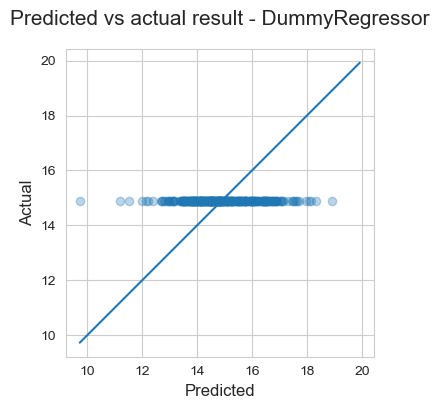

<IPython.core.display.Javascript object>

In [87]:
%%notify -m "Fitting done"

scores_test_dummy, gs_results_dummy, gs_dummy = regressor(X, y_nrj, DummyRegressor())

## <a name='3.2'>3.2 Linear regression</a> 

CROSS VALIDATION RESULTS
	 - Metrics:
		 - R2: 0.590 (+/-0.054)
		 - MAE: 0.621 (+/-0.034)
		 - RMSE: 0.849 (+/-0.068)
TEST RESULTS
	 - Metrics:
		 - R2: 0.588
		 - MAE: 0.592
		 - RMSE: 0.815


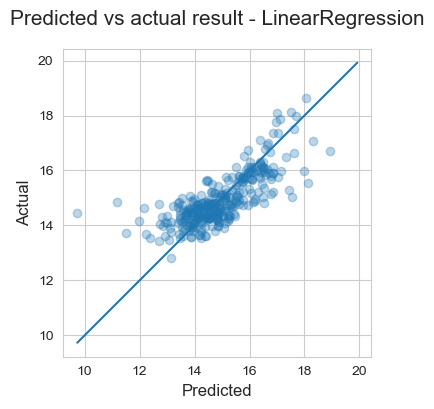

<IPython.core.display.Javascript object>

In [88]:
%%notify -m "Fitting done"

scores_test_lin, gs_results_lin, gs_lin = regressor(X, y_nrj, LinearRegression())

## <a name='3.3'>3.3 Ridge regression</a> 

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__alpha: 4.5
	 - Metrics:
		 - R2: 0.593 (+/-0.052)
		 - MAE: 0.621 (+/-0.039)
		 - RMSE: 0.846 (+/-0.068)
TEST RESULTS
	 - Metrics:
		 - R2: 0.589
		 - MAE: 0.591
		 - RMSE: 0.815


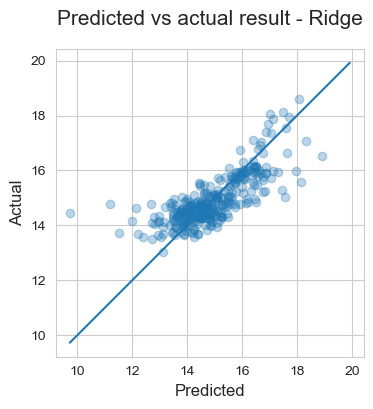

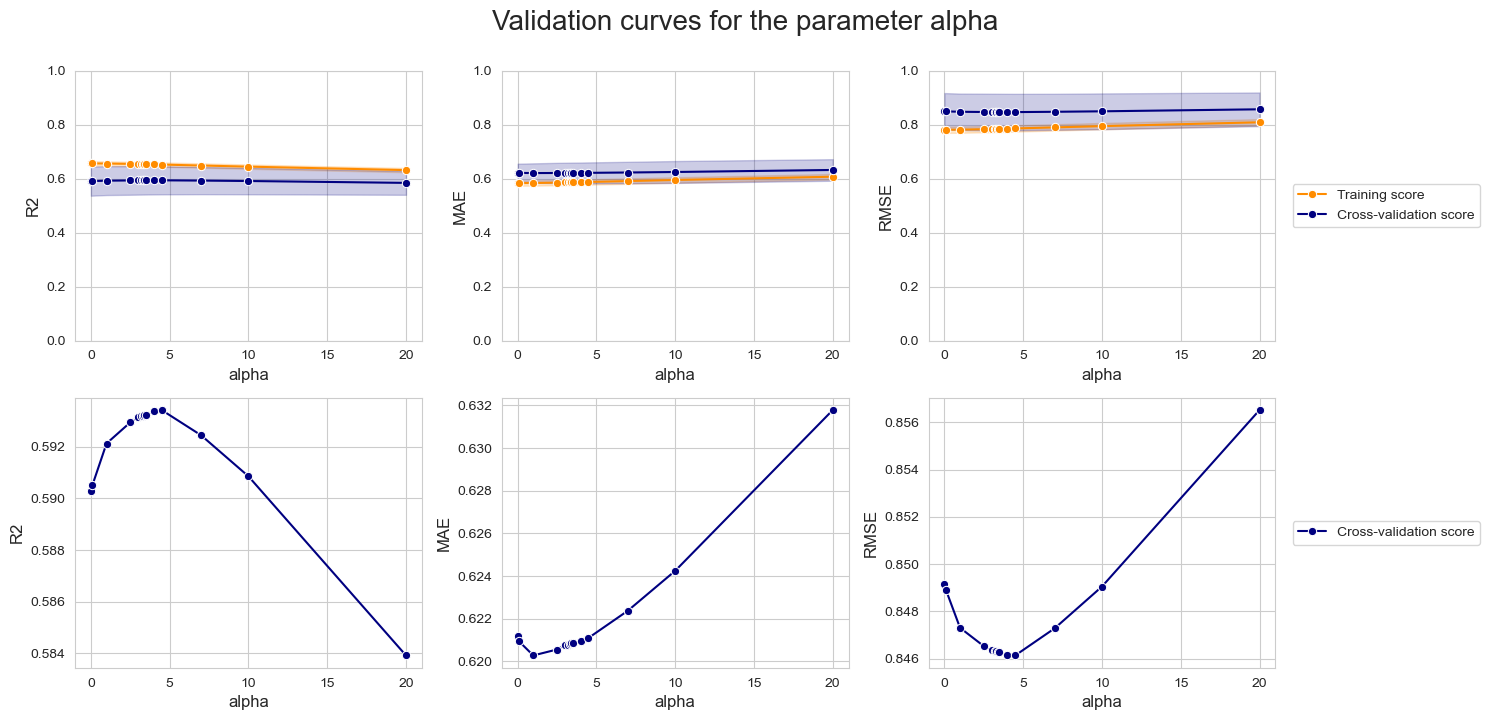

<IPython.core.display.Javascript object>

In [89]:
%%notify -m "Fitting done"

params_ridge = {
    'model__alpha': [0.01,0.1, 1, 2.5, 3, 3.2, 3.3, 3.4, 3.5, 4, 4.5, 7, 10, 20]
               }

scores_test_ridge, gs_results_ridge, gs_ridge = regressor(X, y_nrj, Ridge(), params_ridge)

## <a name='3.4'>3.4 Lasso regression</a> 

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__alpha: 0.002
	 - Metrics:
		 - R2: 0.596 (+/-0.055)
		 - MAE: 0.616 (+/-0.037)
		 - RMSE: 0.843 (+/-0.070)
TEST RESULTS
	 - Metrics:
		 - R2: 0.591
		 - MAE: 0.588
		 - RMSE: 0.812


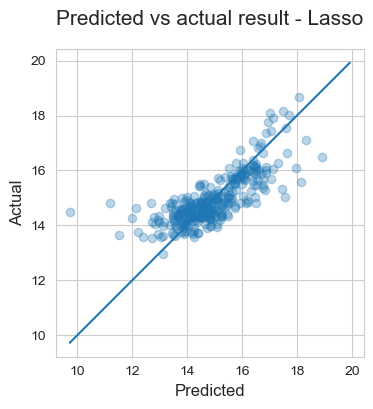

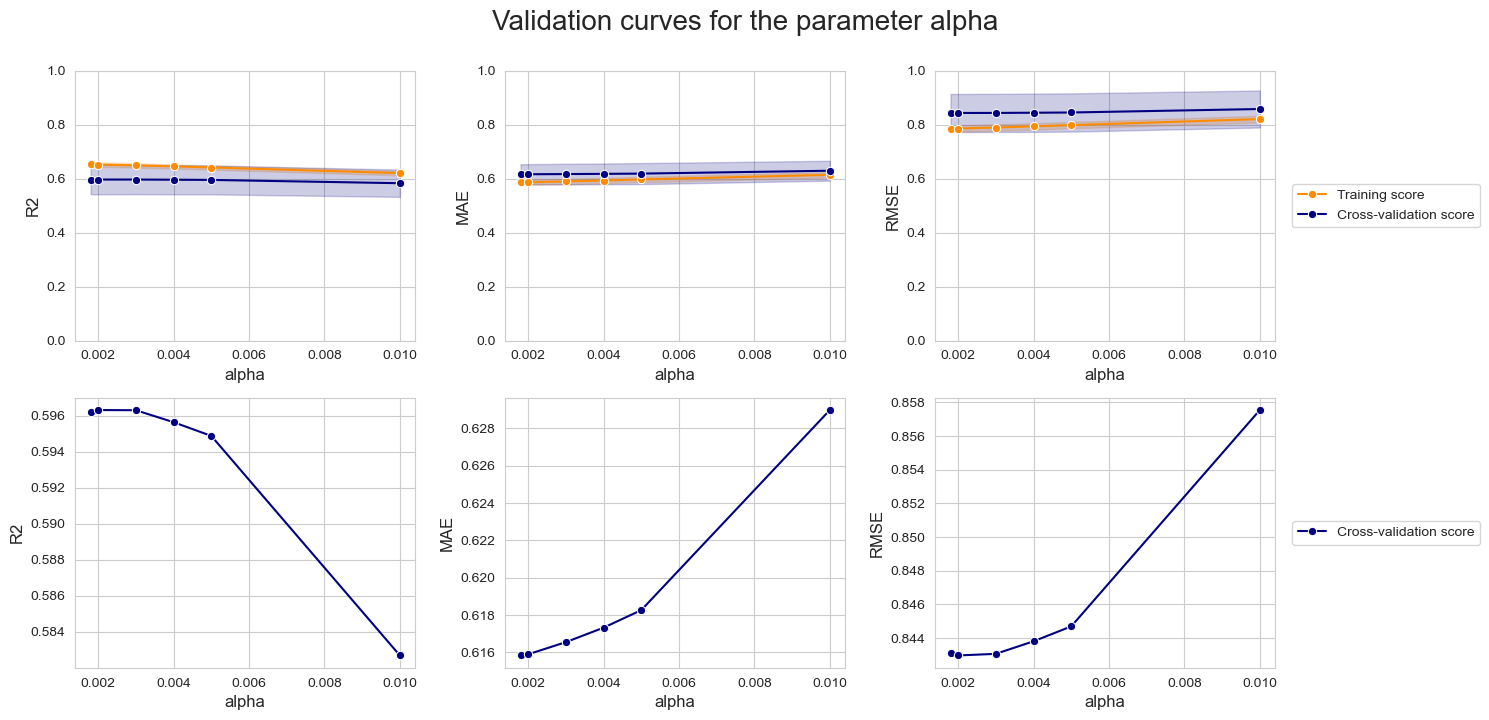

<IPython.core.display.Javascript object>

In [90]:
%%notify -m "Fitting done"

params_lasso = {
    'model__alpha': [1.8e-3, 2e-3, 3e-3, 4e-3, 5e-3, 0.01]
               }

scores_test_lasso, gs_results_lasso, gs_lasso = regressor(X, y_nrj, Lasso(), params_lasso)

## <a name='3.5'>3.5 SVM</a>

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__C: 30
		 - model__gamma: 0.011
		 - model__kernel: rbf
	 - Metrics:
		 - R2: 0.729 (+/-0.020)
		 - MAE: 0.498 (+/-0.023)
		 - RMSE: 0.691 (+/-0.033)
TEST RESULTS
	 - Metrics:
		 - R2: 0.695
		 - MAE: 0.480
		 - RMSE: 0.702


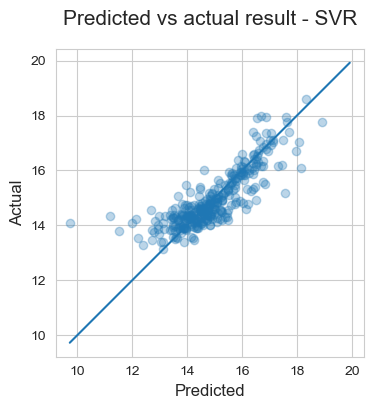

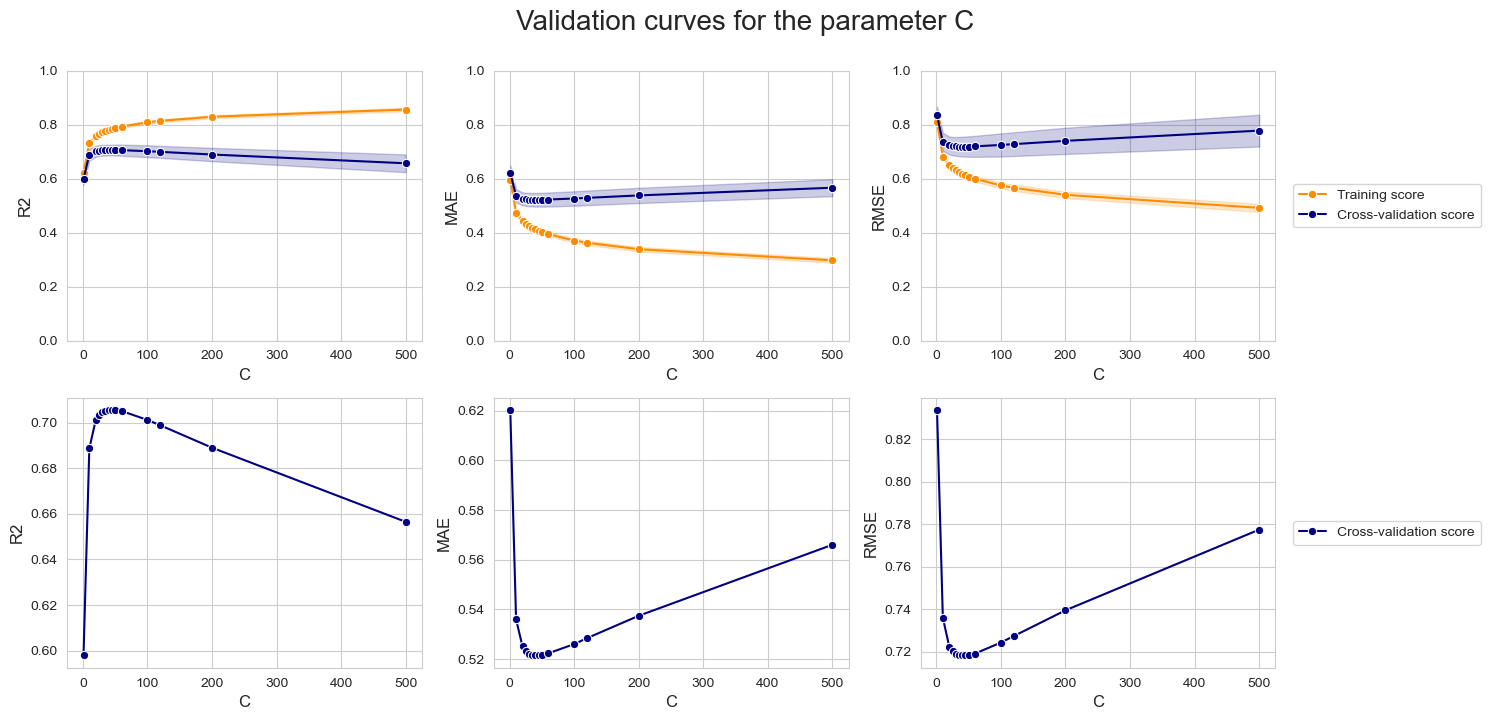

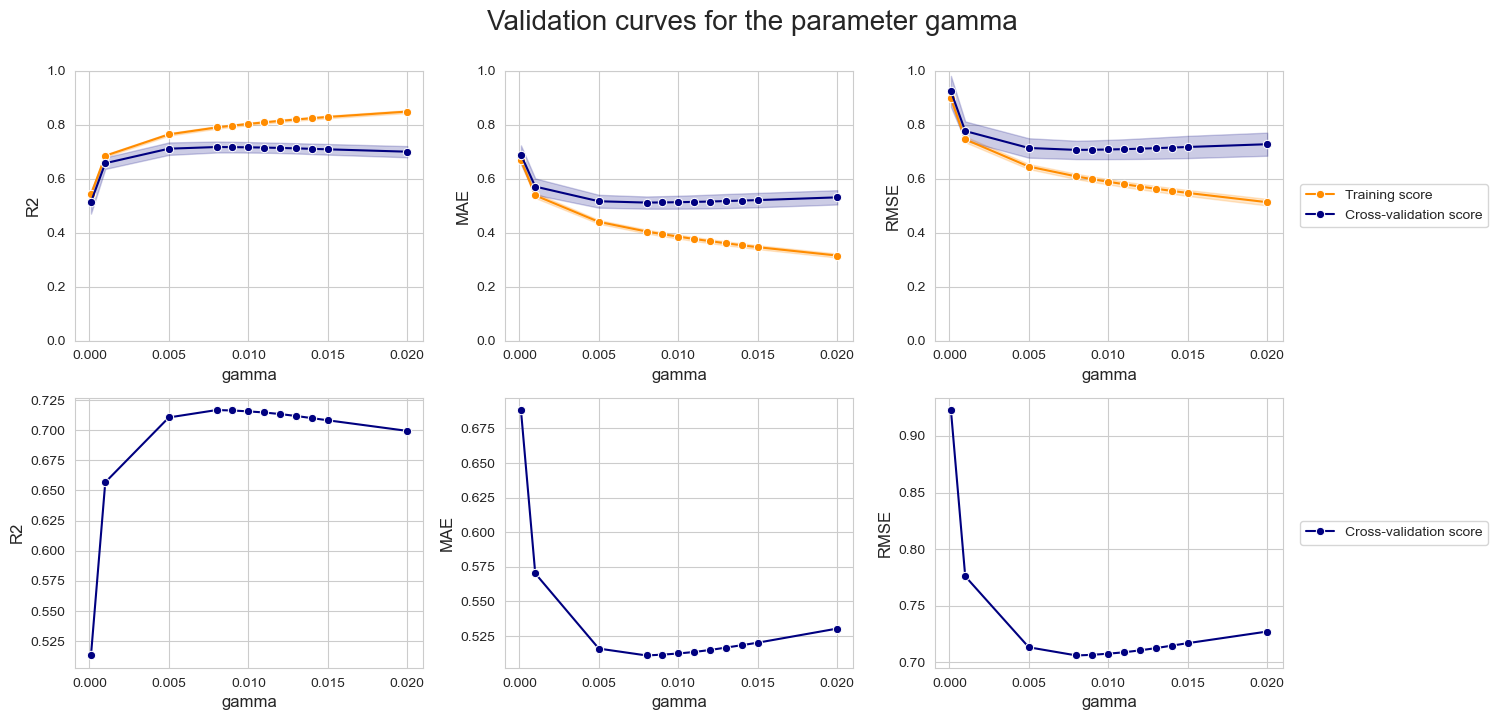

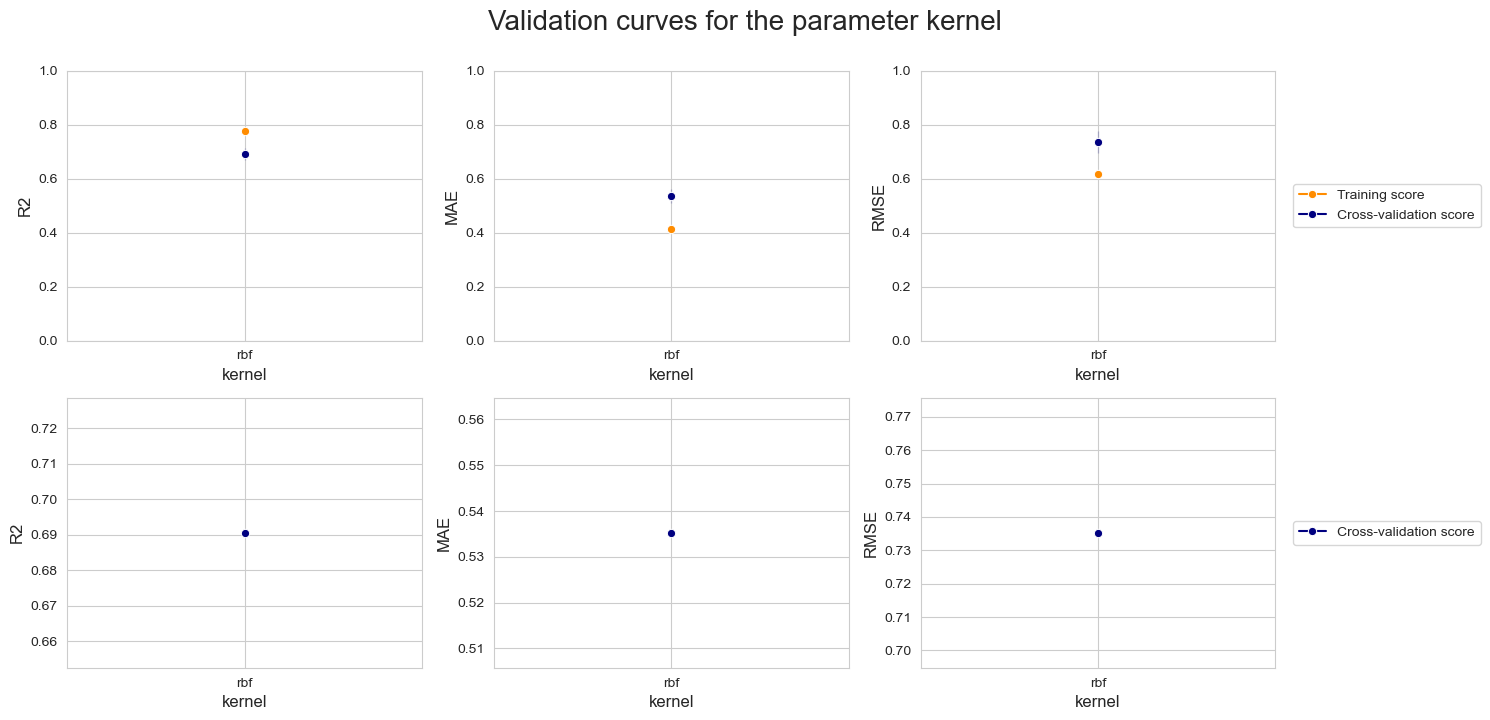

<IPython.core.display.Javascript object>

In [92]:
%%notify -m "Fitting done"

params_svr = {
    'model__C': [1, 10, 20, 25, 30, 35, 40, 45, 50, 60, 100, 120, 200, 500],
    'model__gamma': [1e-4, 0.001, 0.005, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.02],
    'model__kernel': ['rbf']
             }

scores_test_svr, gs_results_svr, gs_svr = regressor(X, y_nrj, SVR(), params_svr)

## <a name='3.6'>3.6 Random forest</a>

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__max_depth: 100
		 - model__n_estimators: 300
	 - Metrics:
		 - R2: 0.704 (+/-0.024)
		 - MAE: 0.513 (+/-0.025)
		 - RMSE: 0.722 (+/-0.034)
TEST RESULTS
	 - Metrics:
		 - R2: 0.703
		 - MAE: 0.464
		 - RMSE: 0.692


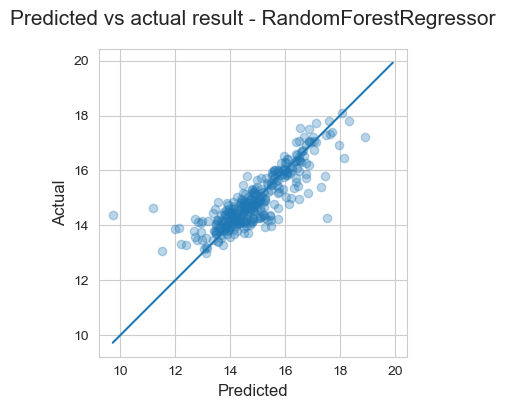

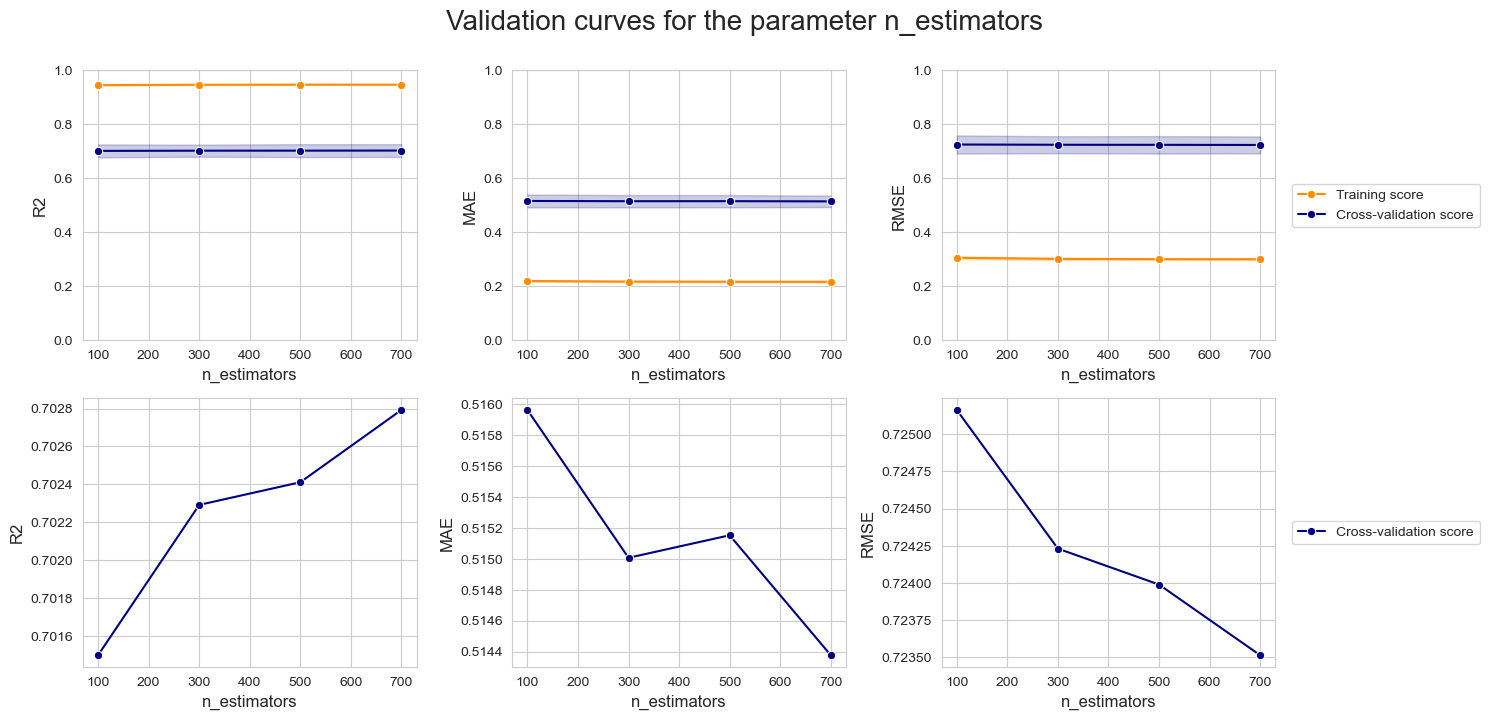

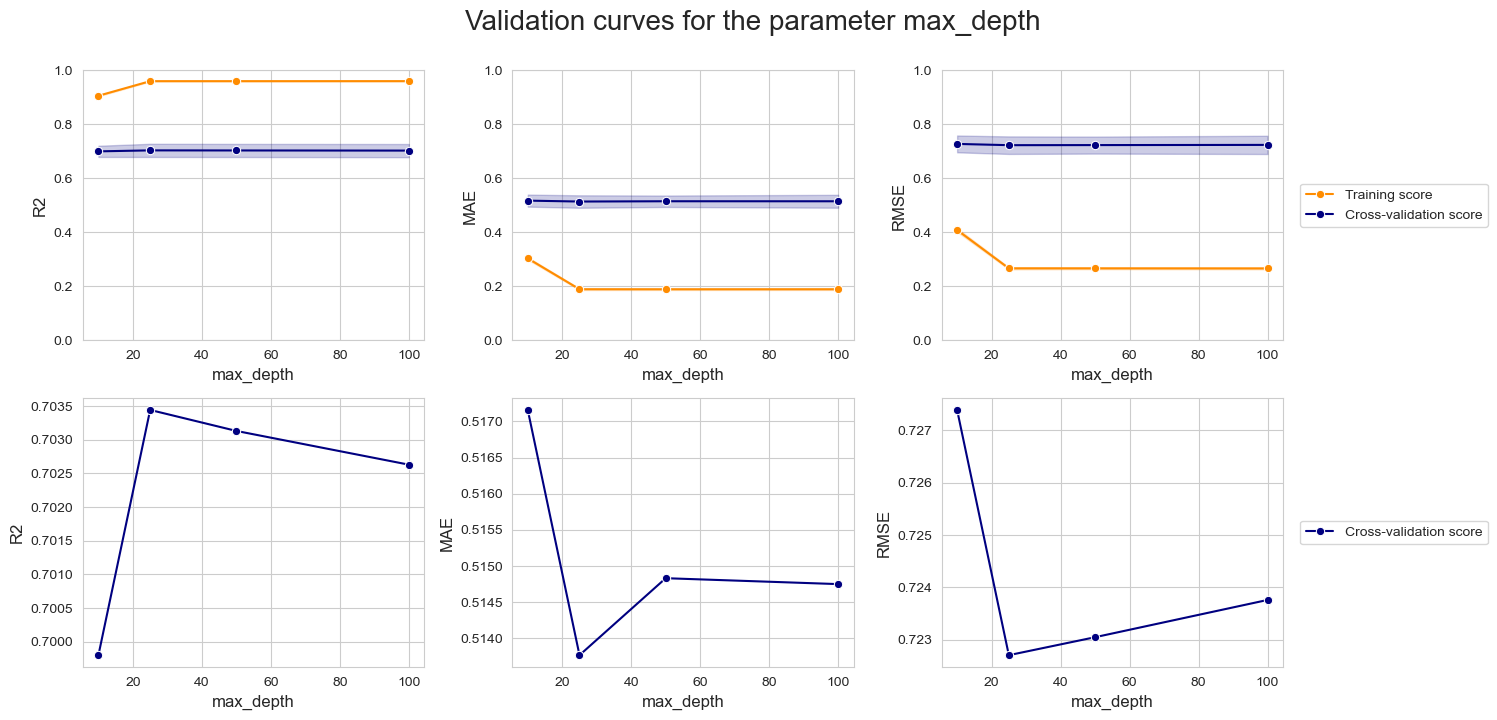

<IPython.core.display.Javascript object>

In [91]:
%%notify -m "Fitting done"

params_rf = {
        'model__n_estimators': [100, 300, 500, 700], # Nb of trees
        'model__max_depth': [10, 25, 50, 100] # Max nb of levels in tree
        #'model__max_features': ['auto', 'sqrt'], # Nb of features to consider at every split
        #'model__min_samples_split': [2, 5, 10], # Min nb of samples required to split a node
        #'model__min_samples_leaf': [1, 2, 4], # Min nb of samples required at each leaf node
        #'model__bootstrap': [True, False] # Method of selecting samples for training each tree
            } 

scores_test_rf, gs_results_rf, gs_rf = regressor(X, y_nrj, RandomForestRegressor(), params_rf)

## <a name='3.7'>3.7 XGBoost</a>

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__n_estimators: 70
	 - Metrics:
		 - R2: 0.727 (+/-0.027)
		 - MAE: 0.496 (+/-0.022)
		 - RMSE: 0.693 (+/-0.039)
TEST RESULTS
	 - Metrics:
		 - R2: 0.723
		 - MAE: 0.451
		 - RMSE: 0.668


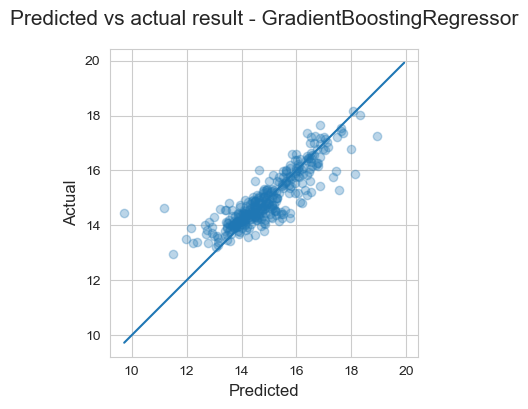

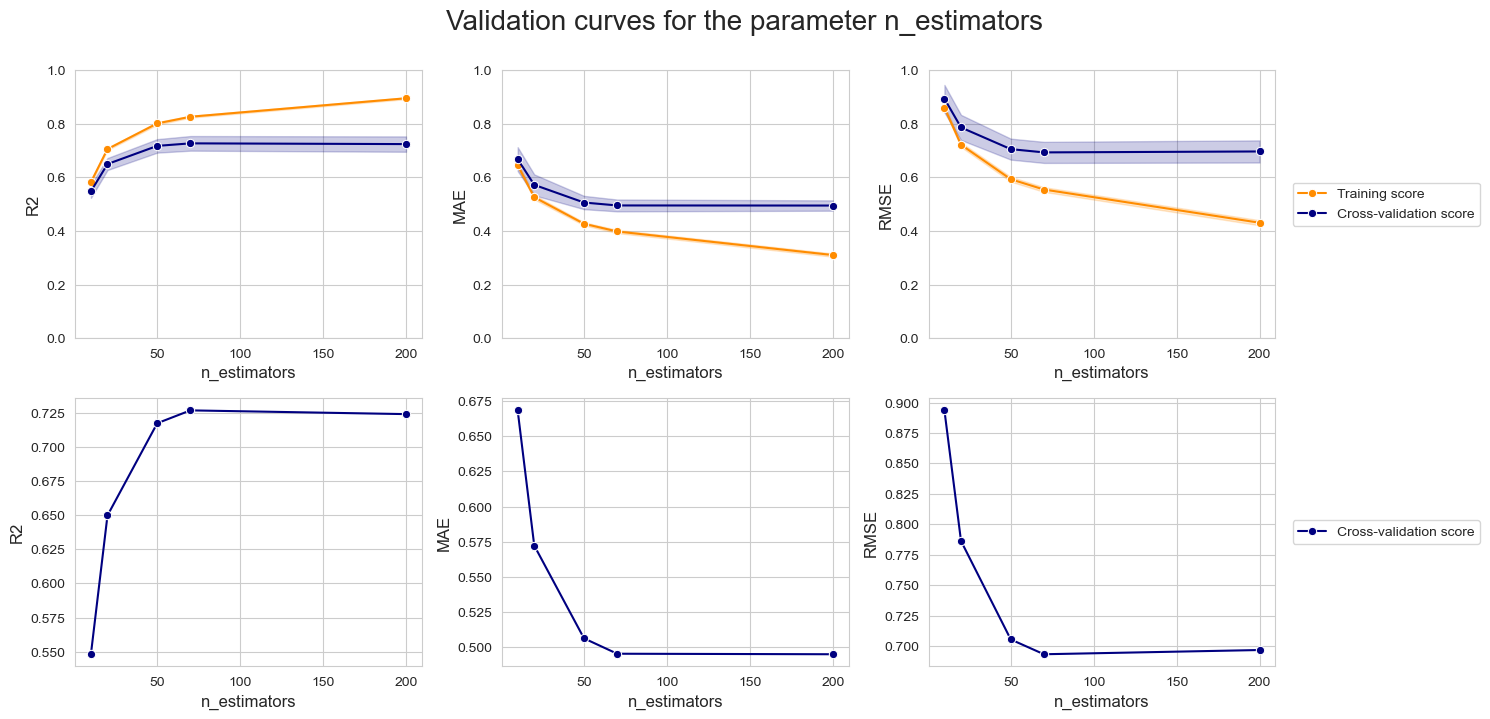

<IPython.core.display.Javascript object>

In [117]:
%%notify -m "Fitting done"

params_gb = {
    'model__n_estimators':[10, 20, 50, 70, 200],
            }

scores_test_gb, gs_results_gb, gs_gb = regressor(X, y_nrj, GradientBoostingRegressor(), params_gb)

# <a name='4'>4. Baseline for Energy </a>

## <a name='4.1'>4.1 Models comparison</a>

In [118]:
results = [scores_test_dummy,
           scores_test_lin,
           scores_test_ridge,
           scores_test_lasso,
           scores_test_svr,
           scores_test_rf,
           scores_test_gb
          ]
model_names = ['Dummy regressor',
               'Linear regression',
               'Ridge regression',
               'Lasso regression',
               'SVM',
               'Random forest',
               'XGBoost'
              ]
comparison = pd.DataFrame(results, columns=['R2', 'MAE', 'RMSE'])
comparison.insert(0, 'Models', model_names, True)

In [119]:
cm = sns.light_palette('#7B2E3E', as_cmap=True)
comparison_styled = comparison.sort_values('R2', ascending=False).style.background_gradient(cmap=cm, subset='R2')

dfi.export(comparison_styled,'mytable.png')

[0413/182908.970014:INFO:headless_shell.cc(659)] Written to file /var/folders/sj/st52tvf971ngjhz8ft3l9_tr0000gn/T/tmp92cwihae/temp.png.


<div class="alert alert-block alert-info">

XGBoost gives the best results, it is selected as the baseline.
    
</div>

## <a name='4.2'>4.2 XGBoost optimization</a>

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__max_depth: 3
		 - model__max_features: log2
		 - model__min_samples_leaf: 3
		 - model__min_samples_split: 6
		 - model__n_estimators: 300
	 - Metrics:
		 - R2: 0.744 (+/-0.028)
		 - MAE: 0.481 (+/-0.023)
		 - RMSE: 0.671 (+/-0.042)
TEST RESULTS
	 - Metrics:
		 - R2: 0.742
		 - MAE: 0.440
		 - RMSE: 0.645


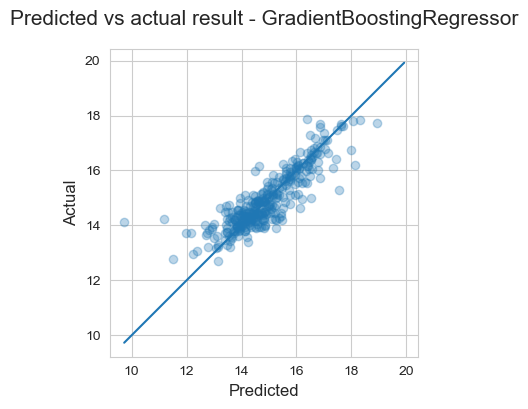

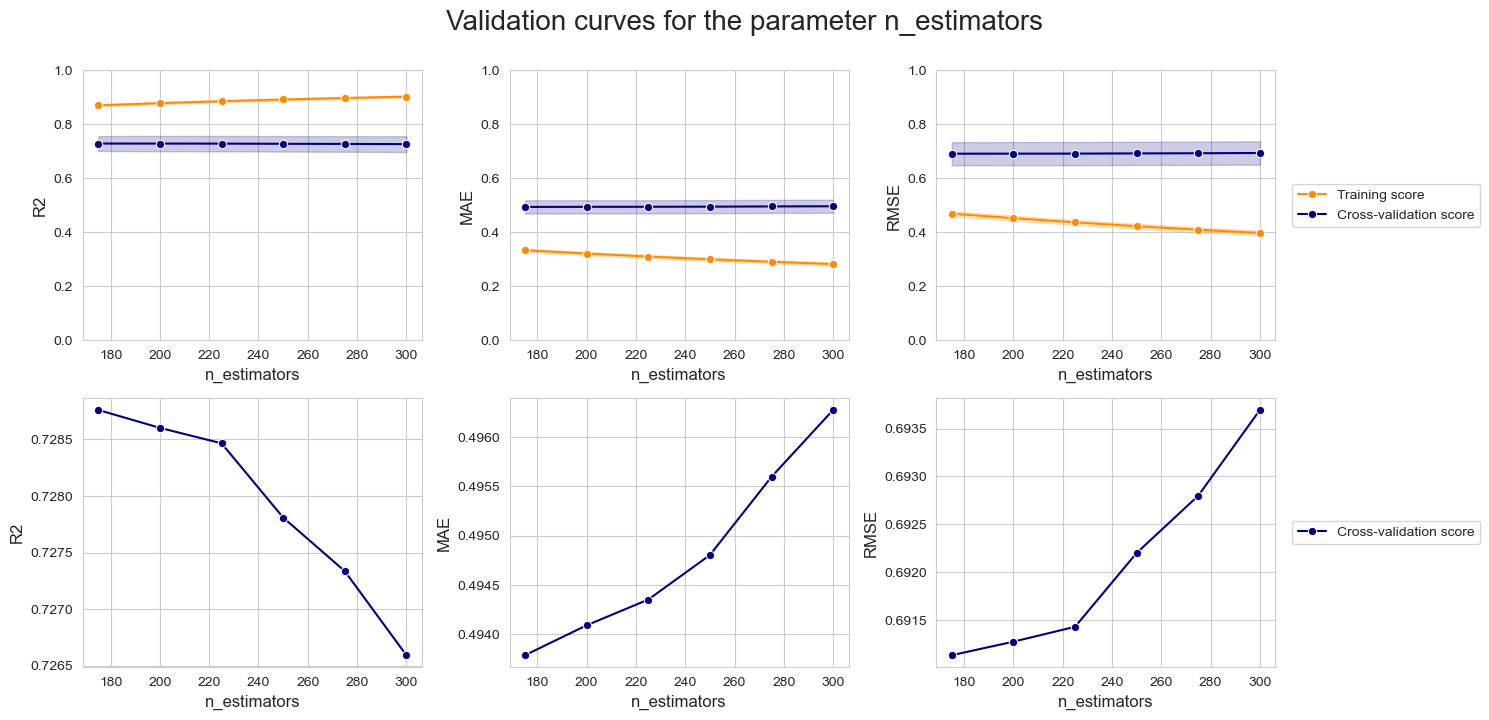

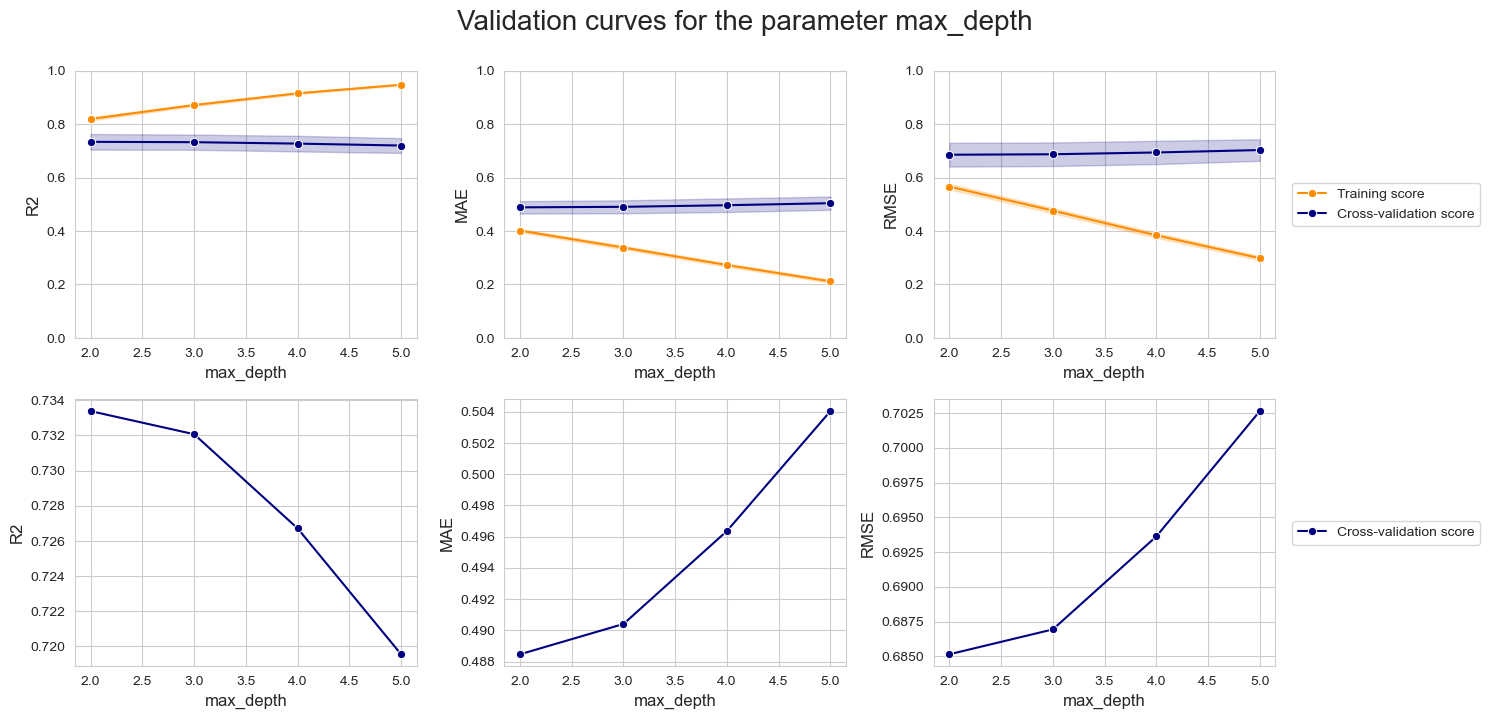

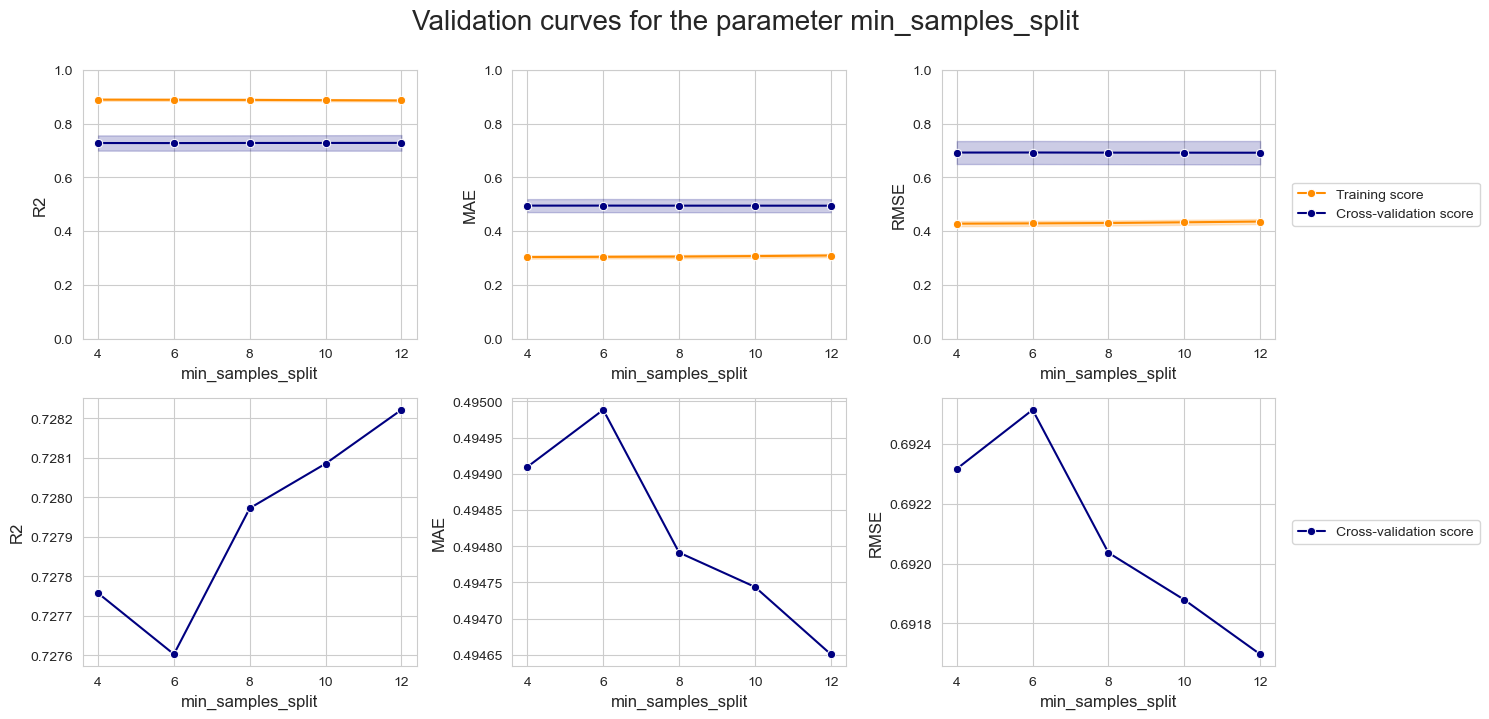

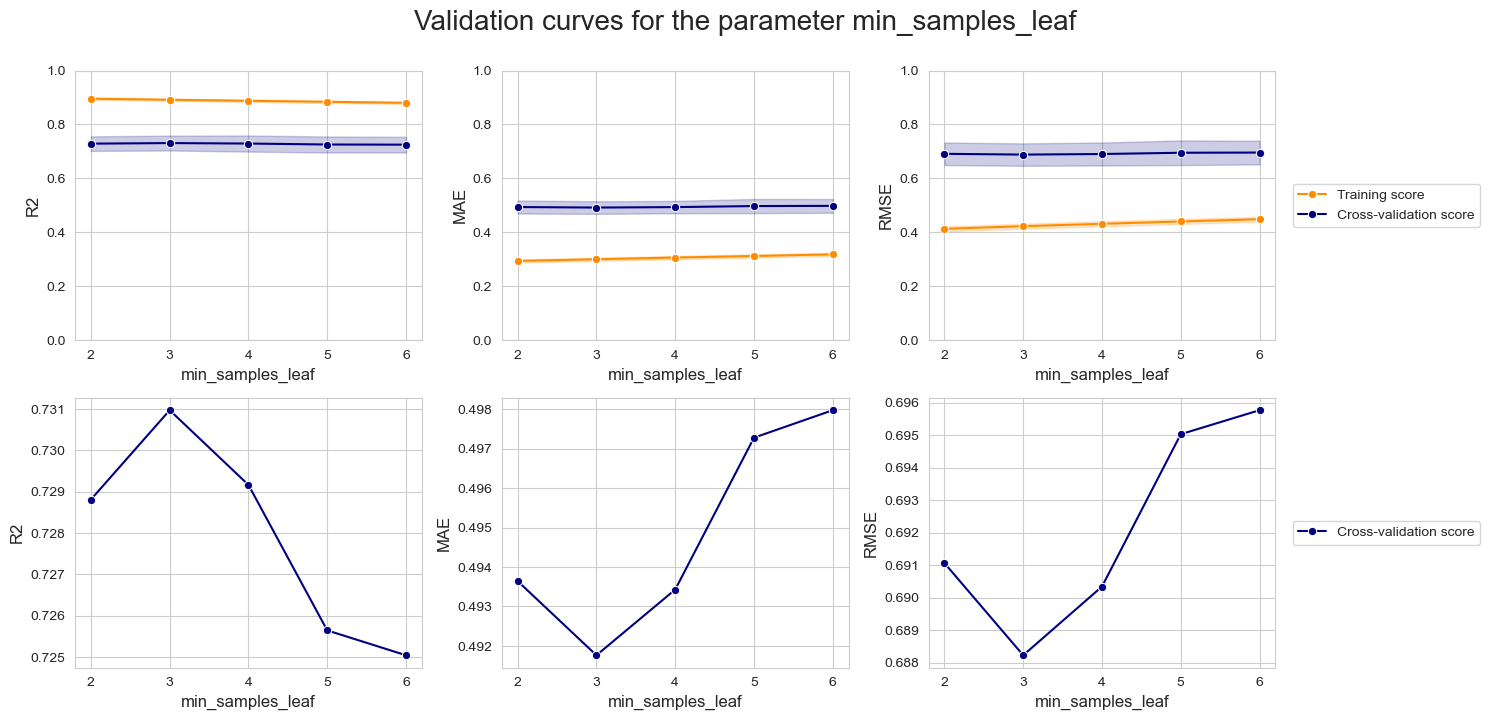

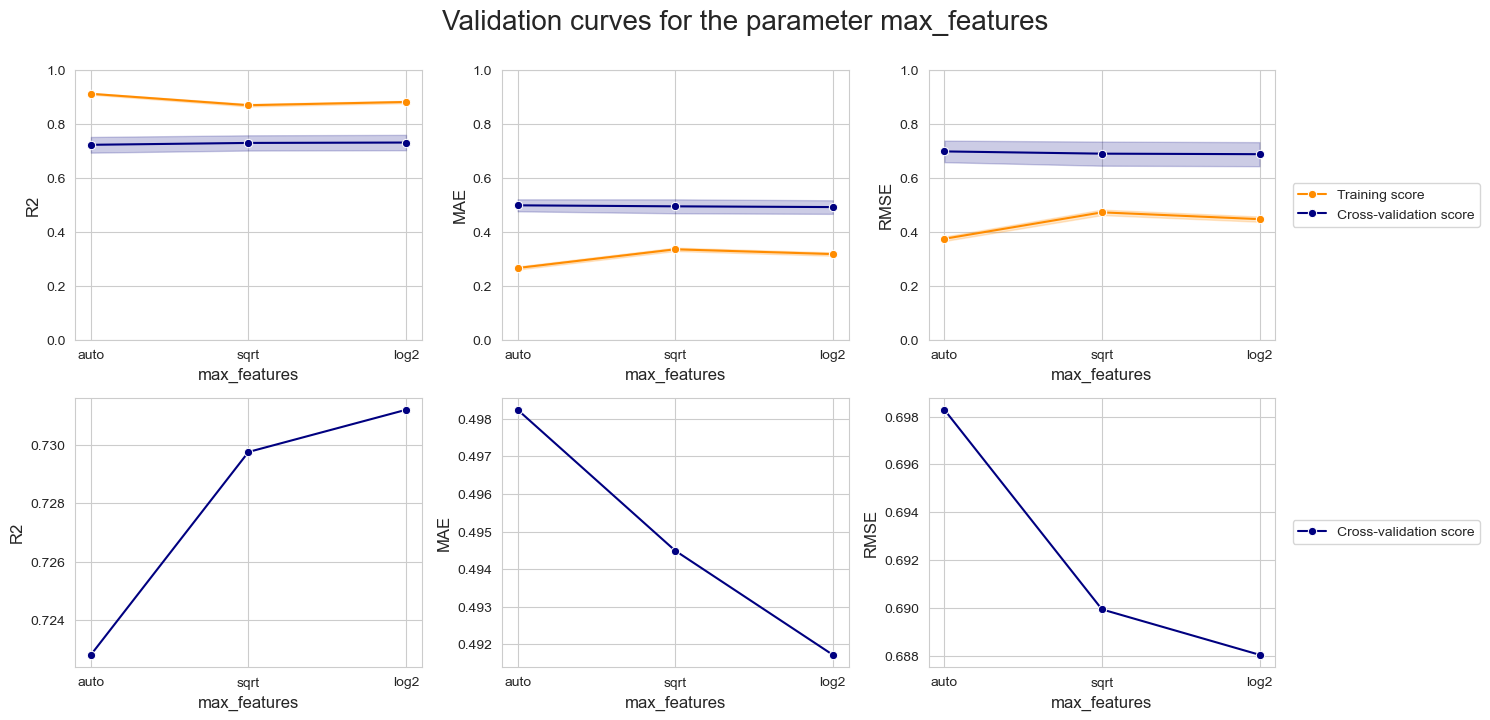

<IPython.core.display.Javascript object>

In [124]:
%%notify -m "Fitting done"

params_gb = {
    'model__n_estimators':[175, 200, 225, 250, 275, 300],
    'model__max_depth':[2, 3, 4, 5],
    'model__min_samples_split':[4, 6, 8, 10, 12],
    'model__min_samples_leaf':[2, 3, 4, 5, 6],
    'model__max_features':['auto', 'sqrt', 'log2']
            }

scores_test_gb_opti, gs_results_gb_opti, gs_gb_opti = regressor(X, y_nrj, GradientBoostingRegressor(), params_gb)

## <a name='4.3'>4.3 XGBoost learning curves</a>

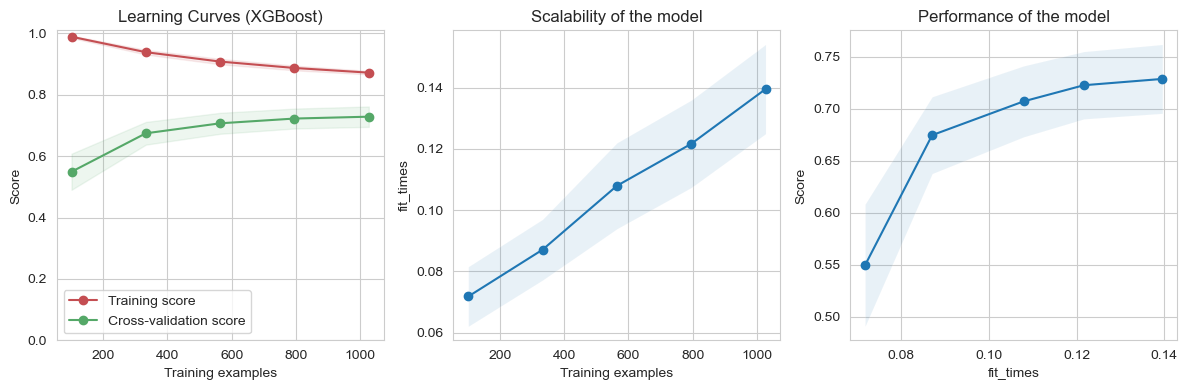

In [168]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid(b=True, which='major', linestyle='-')
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid(b=True, which='major', linestyle='-')
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    
    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid(b=True, which='major', linestyle='-')
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    plt.tight_layout()
    return plt


fig, axes = plt.subplots(1,3, figsize=(12, 4))

title = "Learning Curves (XGBoost)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)


# Step 1 - Preprocessing numerical and categorical features

## 1.1 - KNN Imputation and standard scaling of numerical features
numeric_features = X.loc[:, X.columns != 'OSEBuildingID']\
                    .select_dtypes(exclude=['object','category'])\
                    .columns

numeric_transformer = Pipeline(steps=[
                                ('imputer', KNNImputer()),
                                ('scaler', StandardScaler())])

## 1.2 - One hot encoding of categorical features
categorical_features = X.loc[:, X.columns != 'OSEBuildingID']\
                        .select_dtypes(exclude=['int', 'float'])\
                        .columns

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

## 1.3 - ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y_nrj, train_size=0.8, random_state=1)

model = GradientBoostingRegressor(max_depth=3,
                                  max_features='log2',
                                  min_samples_leaf=3,
                                  min_samples_split=6,
                                  n_estimators=300)


# Step 3 - Pipeline for preprocessor and model

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])


plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes[:], ylim=(0, 1.01), cv=cv, n_jobs=-1
)

plt.savefig('learning_curves_xgboost_energy.png', transparent=True, bbox_inches='tight')
plt.show()

## <a name='4.4'>4.4 ENERGYSTARScore influence</a>

In [125]:
importance_gridsearch = gs_gb_opti.best_estimator_.named_steps['model'].feature_importances_
attributes = list(X)
importance = pd.DataFrame(list(zip(attributes, importance_gridsearch)),
                                 columns =['Feature','Importance'])\
                      .sort_values('Importance', ascending=False)
#https://www.kaggle.com/code/raviolli77/random-forest-in-python/notebook
importance

Feature  Importance
4              Latitude    0.256490
7     NumberofBuildings    0.151118
3          Neighborhood    0.092254
13    TotalInnerSurface    0.077272
6             YearBuilt    0.055201
2   CouncilDistrictCode    0.029889
0         OSEBuildingID    0.029857
5             Longitude    0.029252
9      PropertyGFATotal    0.015017
1   PrimaryPropertyType    0.014671
12      ENERGYSTARScore    0.009396
8        NumberofFloors    0.008321
10  PropertyGFABuilding    0.007596
11   PropertyGFAParking    0.000707

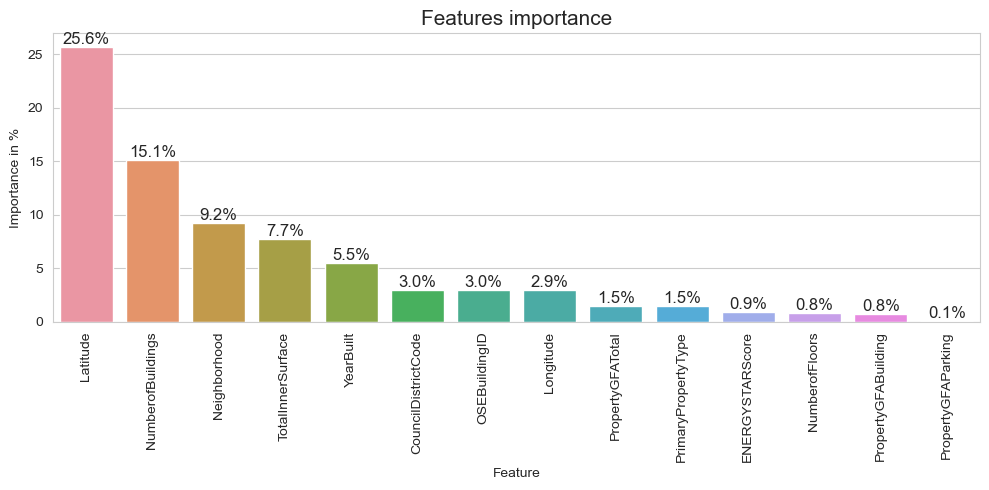

In [127]:
fig, ax = plt.subplots(figsize=(10, 5))

df_len = len(importance.Feature)

sns.barplot(x=importance.Feature, y=importance.Importance*100)

container = ax.containers[0]
ax.bar_label(container,
             labels=[f'{x:.1f}%' for x in container.datavalues],
             label_type='edge',
             size=12)

plt.title('Features importance', fontsize=15)
plt.ylabel('Importance in %')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Features_importance_energy.png', transparent=True, bbox_inches='tight')
plt.show()

<div class="alert alert-block alert-info">

Contribution of ENERGYSTARScore is not significant. It is therefore not worth measuring.
    
</div>

# <a name='5'>5. Models for Emissions </a>

## <a name='5.1'>5.1 Dummy regressor</a> 

CROSS VALIDATION RESULTS
	 - Metrics:
		 - R2: -0.001 (+/-0.001)
		 - MAE: 1.146 (+/-0.054)
		 - RMSE: 1.456 (+/-0.071)
TEST RESULTS
	 - Metrics:
		 - R2: -0.002
		 - MAE: 1.090
		 - RMSE: 1.374


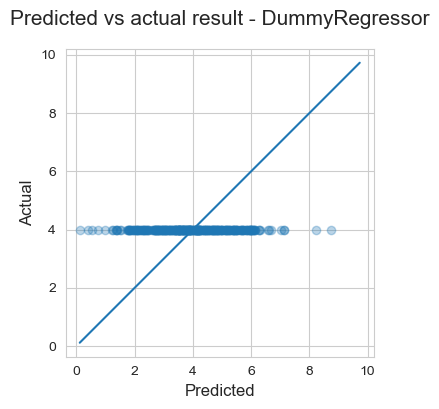

<IPython.core.display.Javascript object>

In [98]:
%%notify -m "Fitting done"

scores_test_dummy2, gs_results_dummy2, gs_dummy2 = regressor(X, y_emi, DummyRegressor())

## <a name='5.2'>5.2 Linear regression</a> 

CROSS VALIDATION RESULTS
	 - Metrics:
		 - R2: 0.446 (+/-0.063)
		 - MAE: 0.836 (+/-0.039)
		 - RMSE: 1.080 (+/-0.069)
TEST RESULTS
	 - Metrics:
		 - R2: 0.431
		 - MAE: 0.801
		 - RMSE: 1.035


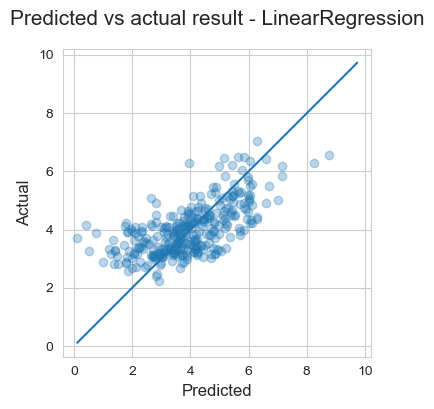

<IPython.core.display.Javascript object>

In [99]:
%%notify -m "Fitting done"

scores_test_lin2, gs_result_lin2, gs_lin2 = regressor(X, y_emi, LinearRegression())

## <a name='5.3'>5.3 Ridge regression</a> 

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__alpha: 4
	 - Metrics:
		 - R2: 0.450 (+/-0.060)
		 - MAE: 0.836 (+/-0.041)
		 - RMSE: 1.077 (+/-0.070)
TEST RESULTS
	 - Metrics:
		 - R2: 0.434
		 - MAE: 0.803
		 - RMSE: 1.033


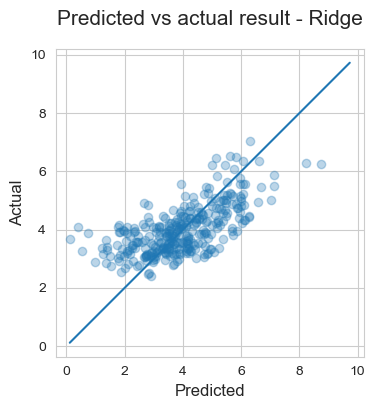

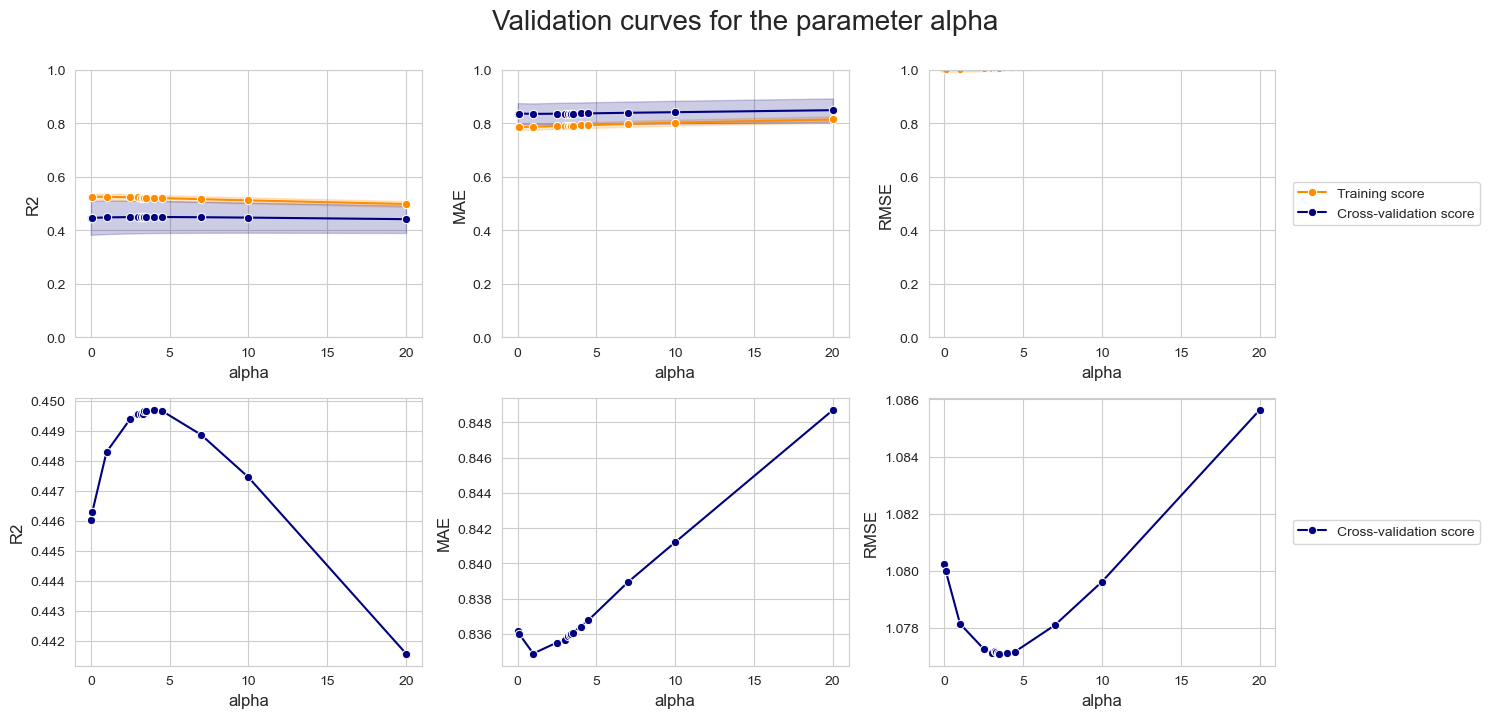

<IPython.core.display.Javascript object>

In [100]:
%%notify -m "Fitting done"

params_ridge2 = {
    'model__alpha': [0.01,0.1, 1, 2.5, 3, 3.2, 3.3, 3.4, 3.5, 4, 4.5, 7, 10, 20]
               }

scores_test_ridge2, gs_results_ridge2, gs_ridge2 = regressor(X, y_emi, Ridge(), params_ridge2)

## <a name='5.4'>5.4 Lasso regression</a> 

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__alpha: 0.002
	 - Metrics:
		 - R2: 0.453 (+/-0.056)
		 - MAE: 0.832 (+/-0.039)
		 - RMSE: 1.074 (+/-0.067)
TEST RESULTS
	 - Metrics:
		 - R2: 0.436
		 - MAE: 0.799
		 - RMSE: 1.031


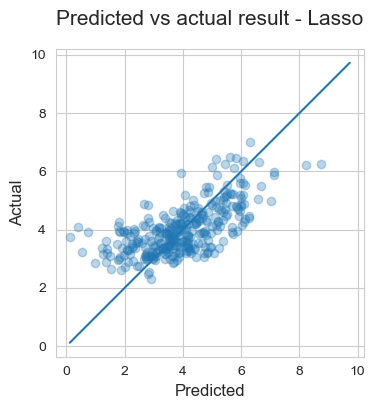

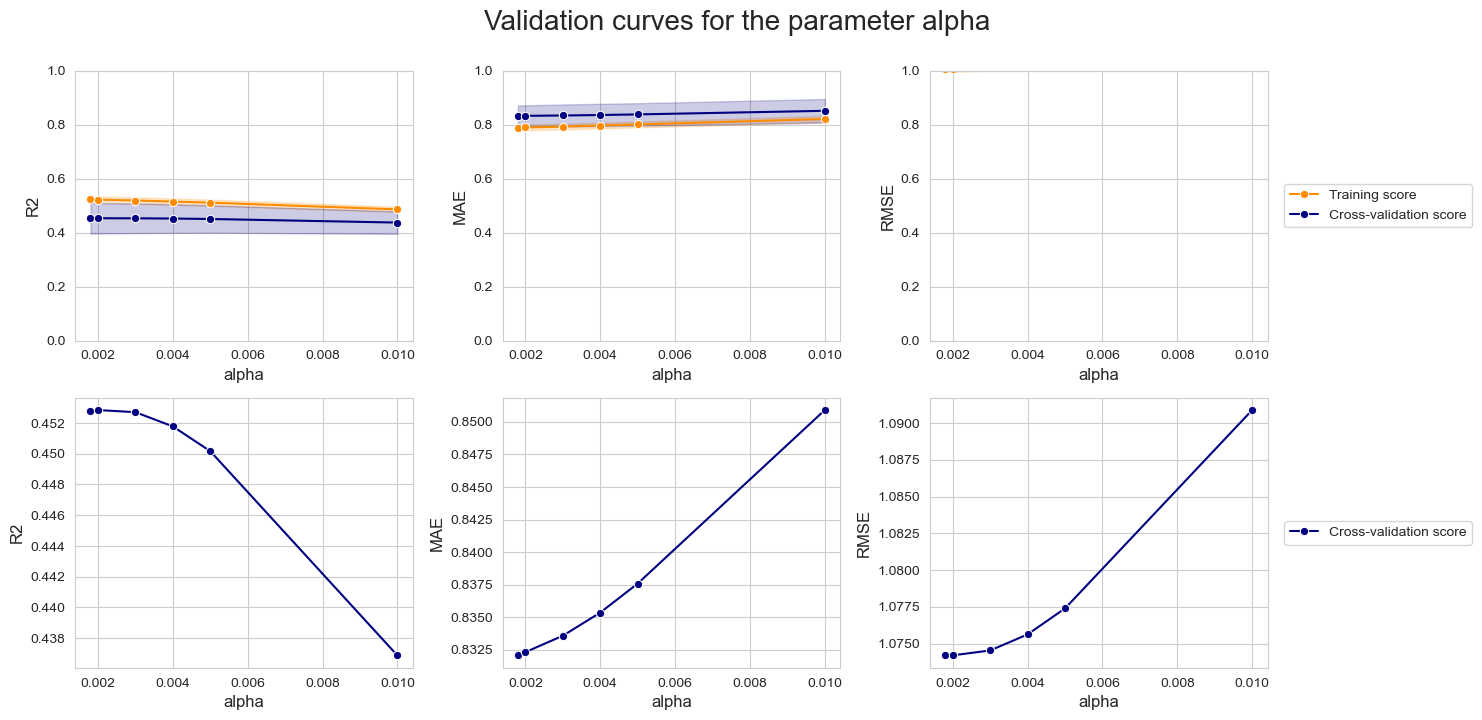

<IPython.core.display.Javascript object>

In [101]:
%%notify -m "Fitting done"

params_lasso2 = {
    'model__alpha': [1.8e-3, 2e-3, 3e-3, 4e-3, 5e-3, 0.01]
               }

scores_test_lasso2, gs_results_lasso2, gs_lasso2 = regressor(X, y_emi, Lasso(), params_lasso2)

In [103]:
#training_rf.sort_values('rank_test_R2')

## <a name='5.5'>5.5 SVM</a>

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__C: 20
		 - model__gamma: 0.012
		 - model__kernel: rbf
	 - Metrics:
		 - R2: 0.557 (+/-0.030)
		 - MAE: 0.754 (+/-0.041)
		 - RMSE: 0.967 (+/-0.044)
TEST RESULTS
	 - Metrics:
		 - R2: 0.516
		 - MAE: 0.712
		 - RMSE: 0.955


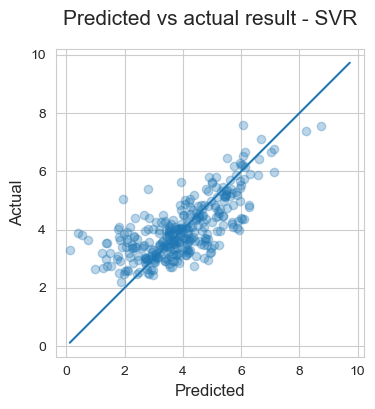

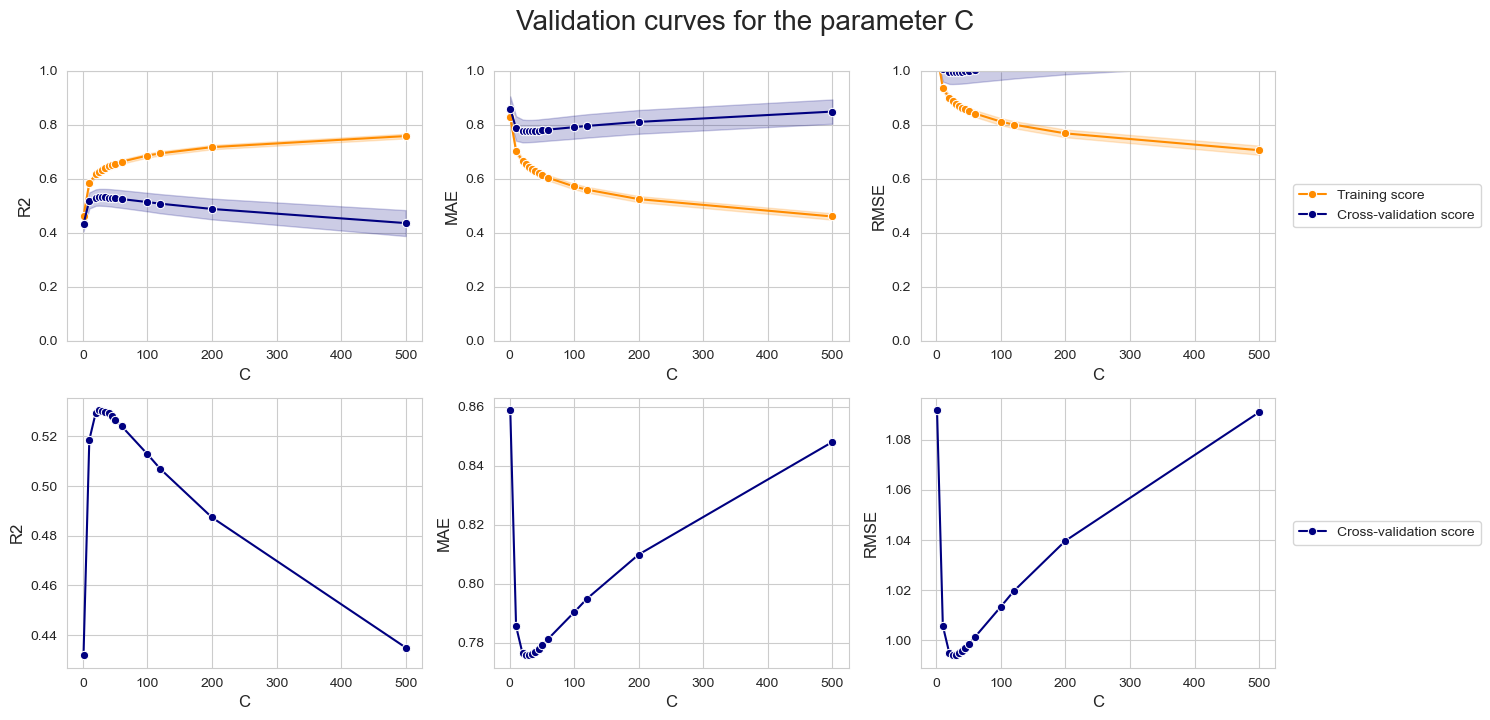

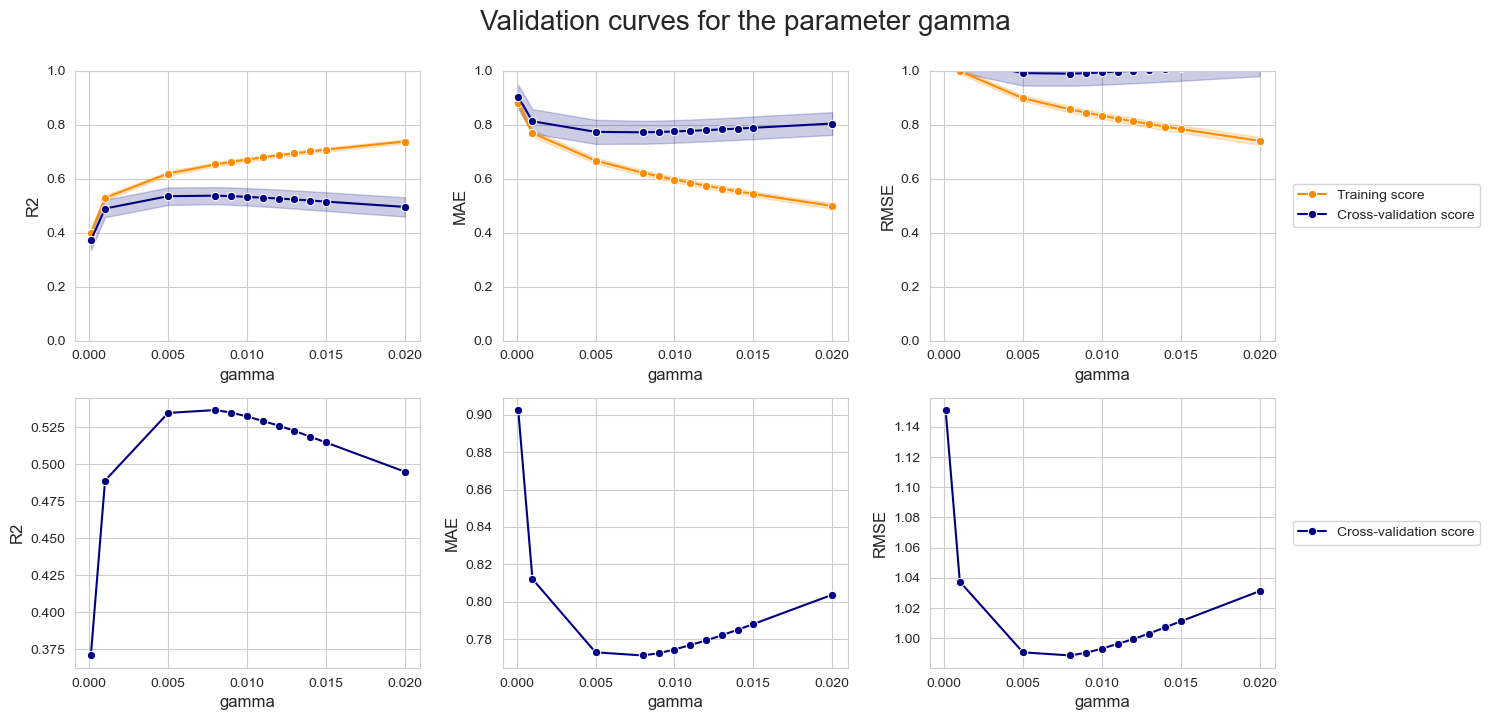

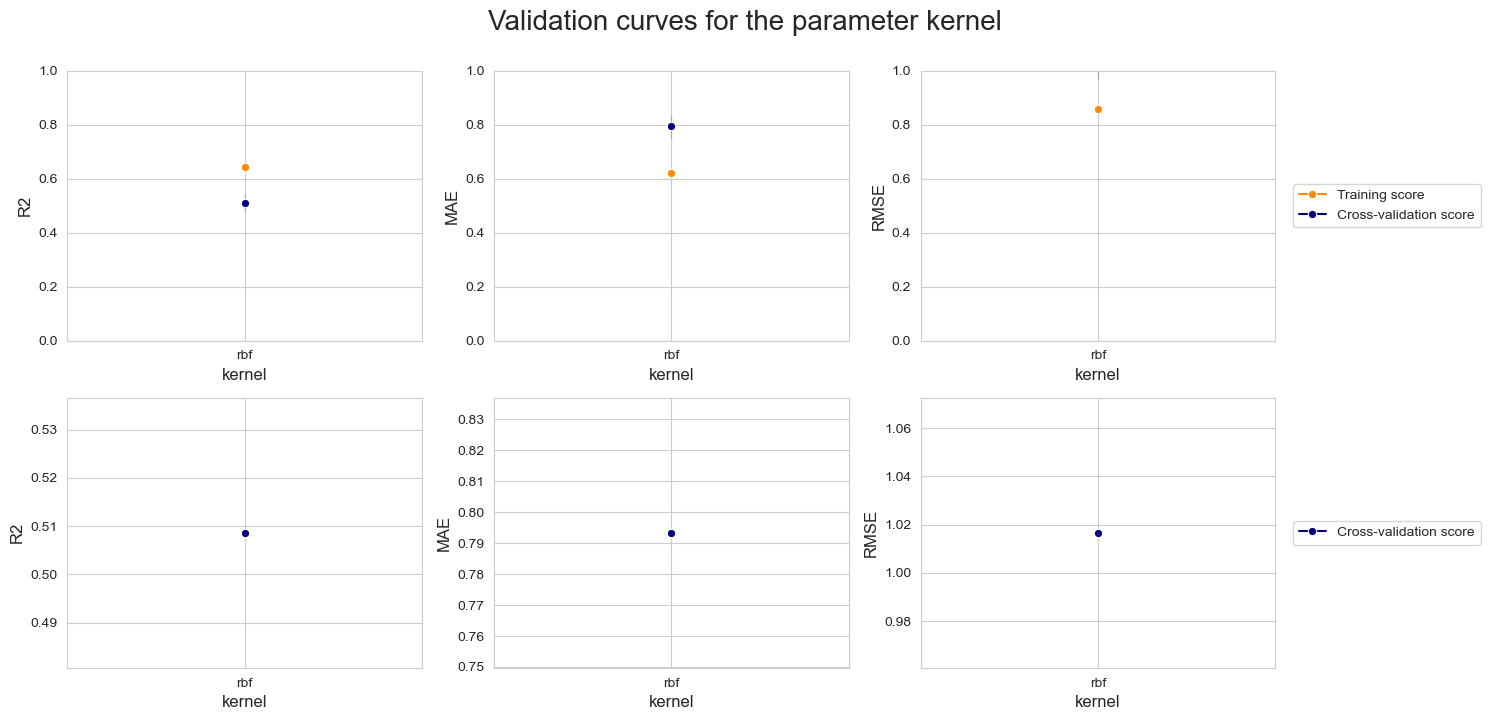

<IPython.core.display.Javascript object>

In [104]:
%%notify -m "Fitting done"

params_svr2 = {
    'model__C': [1, 10, 20, 25, 30, 35, 40, 45, 50, 60, 100, 120, 200, 500],
    'model__gamma': [1e-4, 0.001, 0.005, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.02],
    'model__kernel': ['rbf']
              }

scores_test_svr2, gs_results_svr2, gs_svr2 = regressor(X, y_emi, SVR(), params_svr2)

## <a name='5.6'>5.6 Random forest</a>

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__max_depth: 25
		 - model__n_estimators: 700
	 - Metrics:
		 - R2: 0.530 (+/-0.029)
		 - MAE: 0.787 (+/-0.035)
		 - RMSE: 0.996 (+/-0.041)
TEST RESULTS
	 - Metrics:
		 - R2: 0.542
		 - MAE: 0.723
		 - RMSE: 0.929


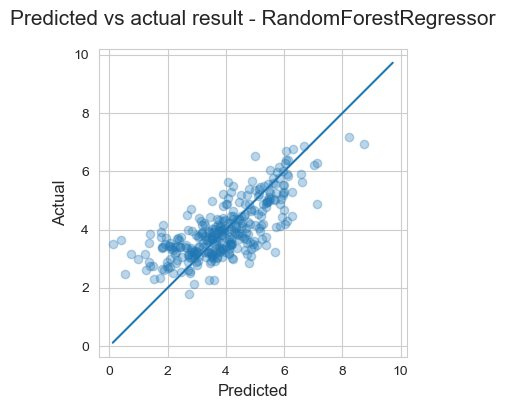

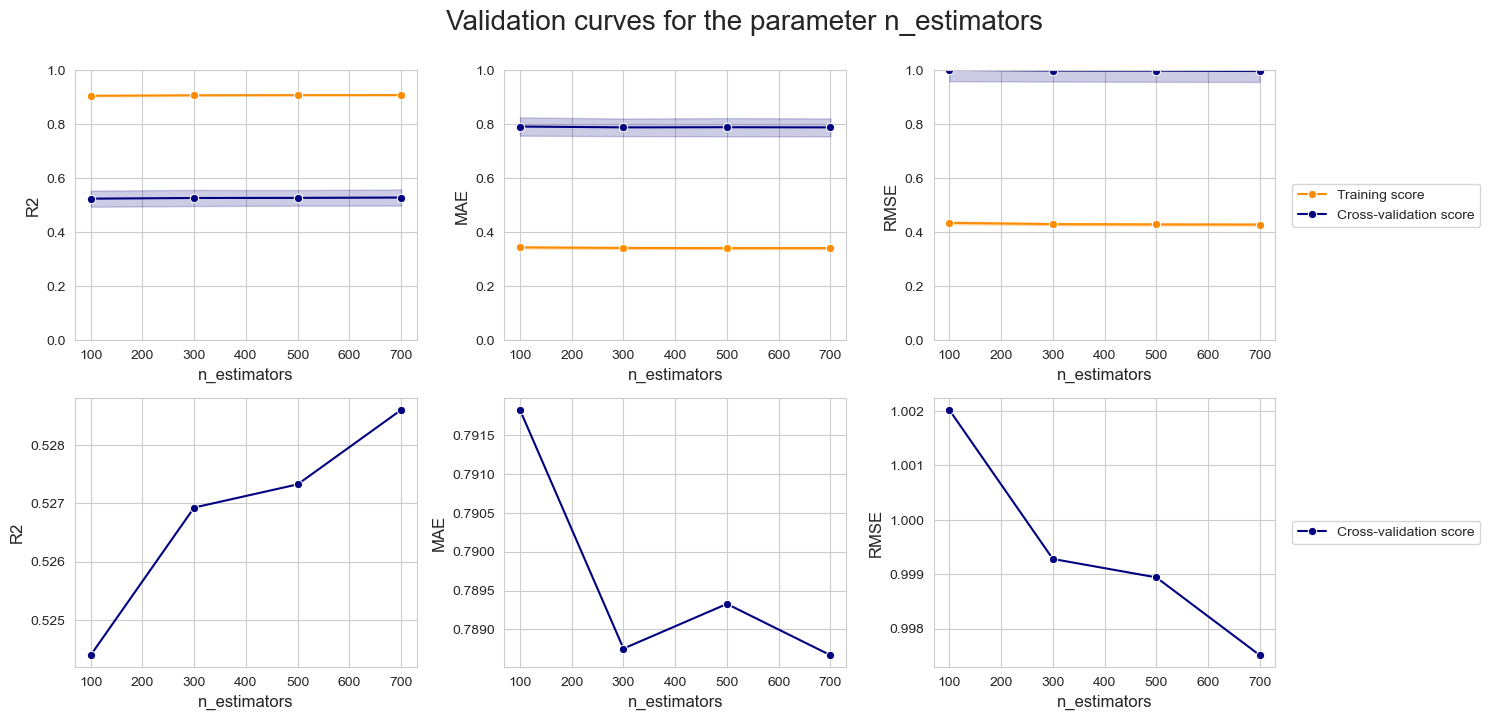

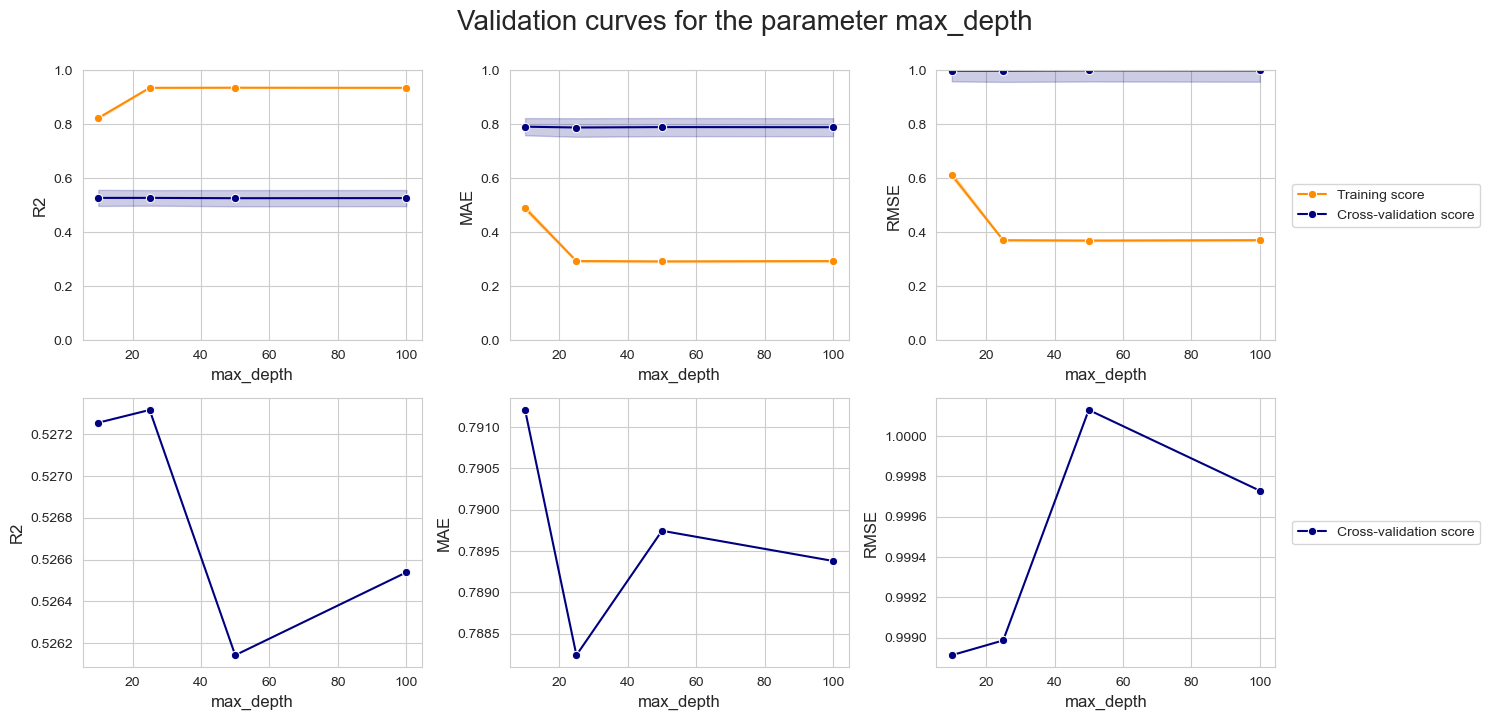

<IPython.core.display.Javascript object>

In [102]:
%%notify -m "Fitting done"

params_rf2 = {
        'model__n_estimators': [100, 300, 500, 700], # Nb of trees
        'model__max_depth': [10, 25, 50, 100] # Max nb of levels in tree
        #'model__max_features': ['auto', 'sqrt'], # Nb of features to consider at every split
        #'model__min_samples_split': [2, 5, 10], # Min nb of samples required to split a node
        #'model__min_samples_leaf': [1, 2, 4], # Min nb of samples required at each leaf node
        #'model__bootstrap': [True, False] # Method of selecting samples for training each tree
            }

scores_test_rf2, gs_results_rf2, gs_rf2 = regressor(X, y_emi, RandomForestRegressor(), params_rf2)

## <a name='5.7'>5.7 XGBoost</a>

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__n_estimators: 100
	 - Metrics:
		 - R2: 0.550 (+/-0.028)
		 - MAE: 0.774 (+/-0.031)
		 - RMSE: 0.974 (+/-0.036)
TEST RESULTS
	 - Metrics:
		 - R2: 0.545
		 - MAE: 0.723
		 - RMSE: 0.926


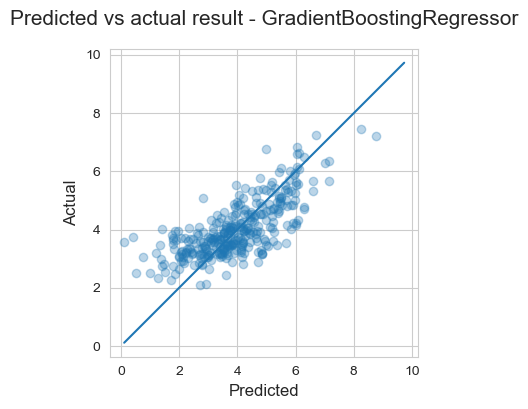

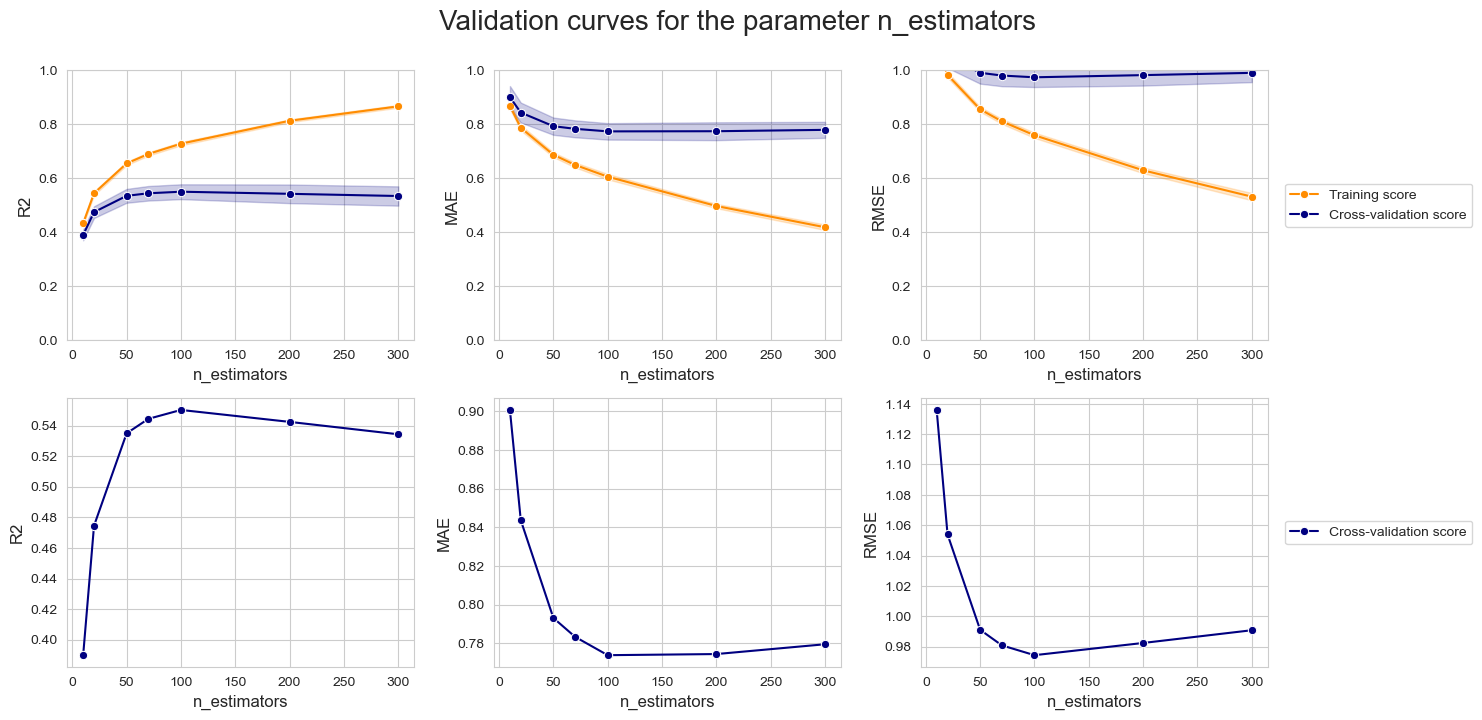

<IPython.core.display.Javascript object>

In [130]:
%%notify -m "Fitting done"

params_gb2 = {
    'model__n_estimators':[10, 20, 50, 70, 100, 200, 300],
            }

scores_test_gb2, gs_results_gb2, gs_gb2 = regressor(X, y_emi, GradientBoostingRegressor(), params_gb2)

# <a name='6'>6. Baseline for Emissions </a>

## <a name='6.1'>6.1 Models comparison</a>

In [131]:
results2 = [scores_test_dummy2,
            scores_test_lin2,
            scores_test_ridge2,
            scores_test_lasso2,
            scores_test_svr2,
            scores_test_rf2,
            scores_test_gb2
          ]
model_names2 = ['Dummy regressor',
         'Linear regression',
         'Ridge regression',
         'Lasso regression',
         'SVM',
         'Random forest',
         'XGBoost'
        ]
comparison2 = pd.DataFrame(results2, columns=['R2', 'MAE', 'RMSE'])
comparison2.insert(0, 'Models', model_names2, True)

In [132]:
cm = sns.light_palette('#7B2E3E', as_cmap=True)
comparison_styled2 = comparison2.sort_values('R2', ascending=False).style.background_gradient(cmap=cm, subset='R2')

dfi.export(comparison_styled2,'mytable2.png')

[0413/190709.501371:INFO:headless_shell.cc(659)] Written to file /var/folders/sj/st52tvf971ngjhz8ft3l9_tr0000gn/T/tmpz80tqnal/temp.png.


<div class="alert alert-block alert-info">

XGBoost again gives the best results, it is selected as the baseline.
    
</div>

## <a name='6.2'>6.2 XGBoost optimization</a>

CROSS VALIDATION RESULTS
	 - Best parameters:
		 - model__max_depth: 2
		 - model__max_features: sqrt
		 - model__min_samples_leaf: 4
		 - model__min_samples_split: 6
		 - model__n_estimators: 250
	 - Metrics:
		 - R2: 0.569 (+/-0.032)
		 - MAE: 0.755 (+/-0.030)
		 - RMSE: 0.953 (+/-0.036)
TEST RESULTS
	 - Metrics:
		 - R2: 0.552
		 - MAE: 0.716
		 - RMSE: 0.919


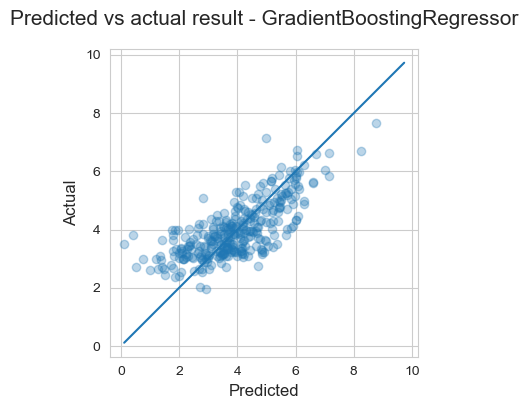

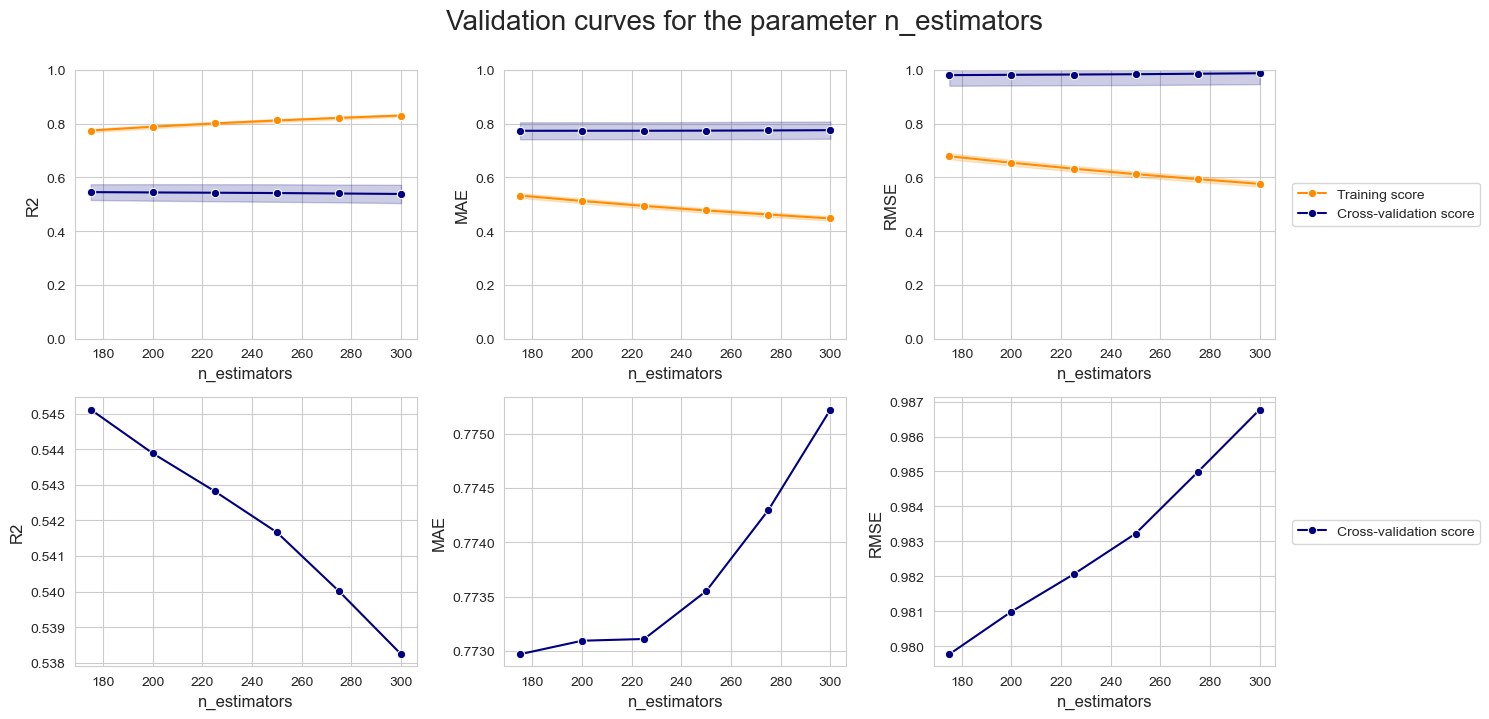

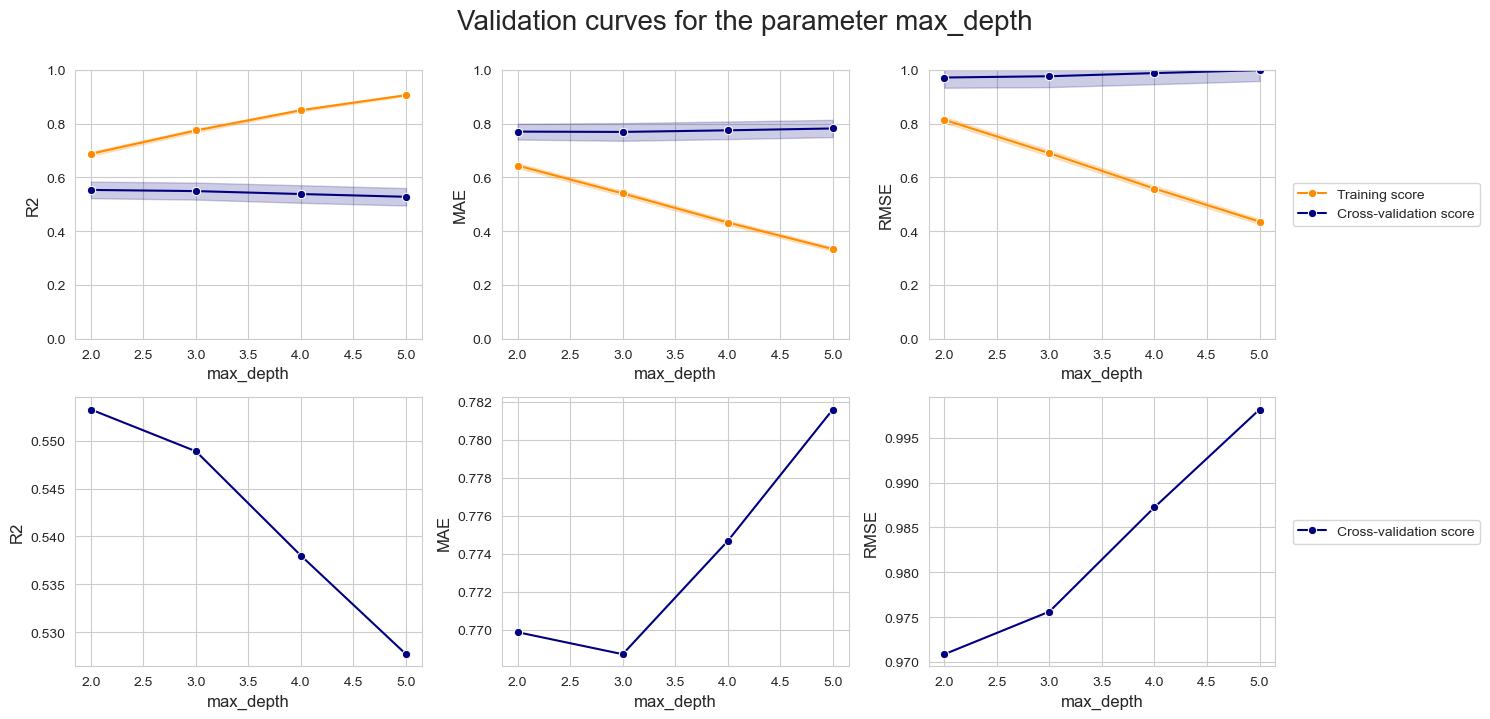

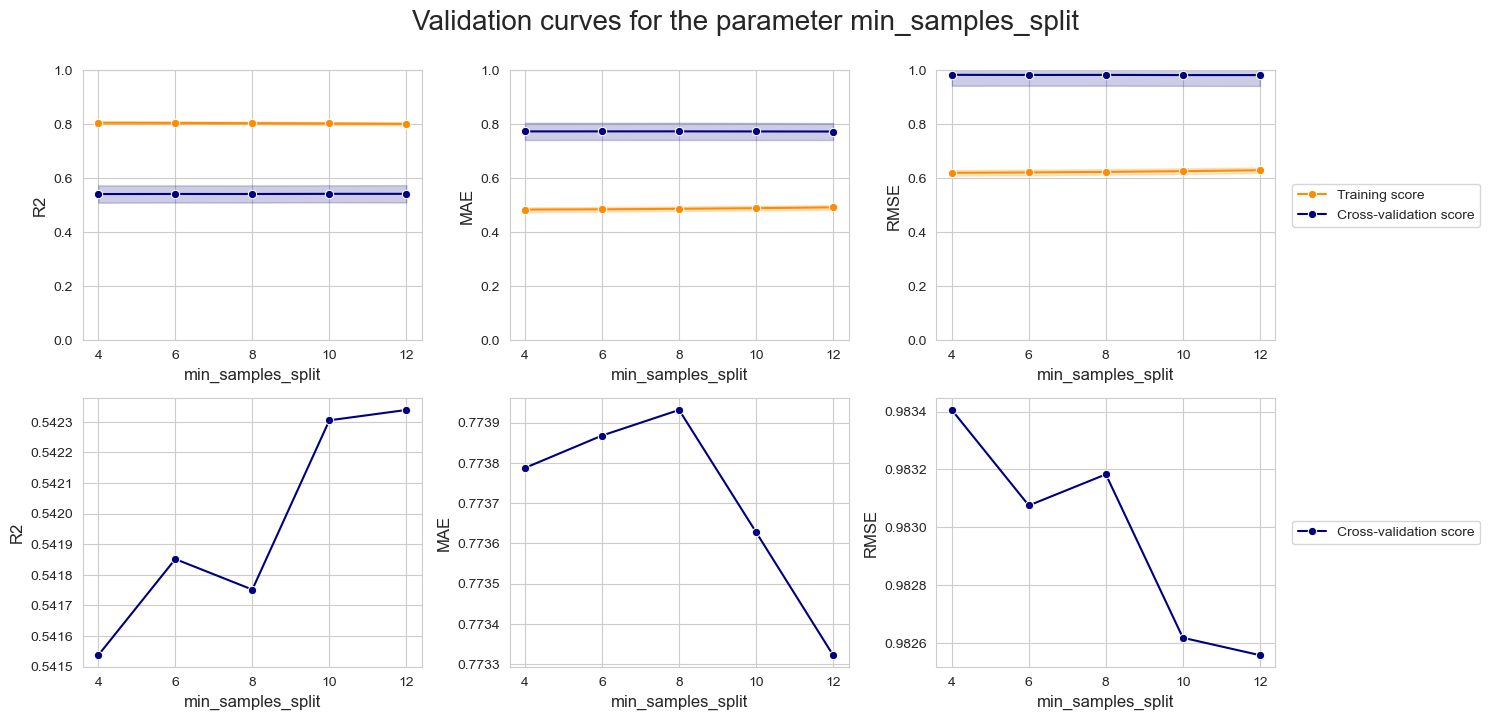

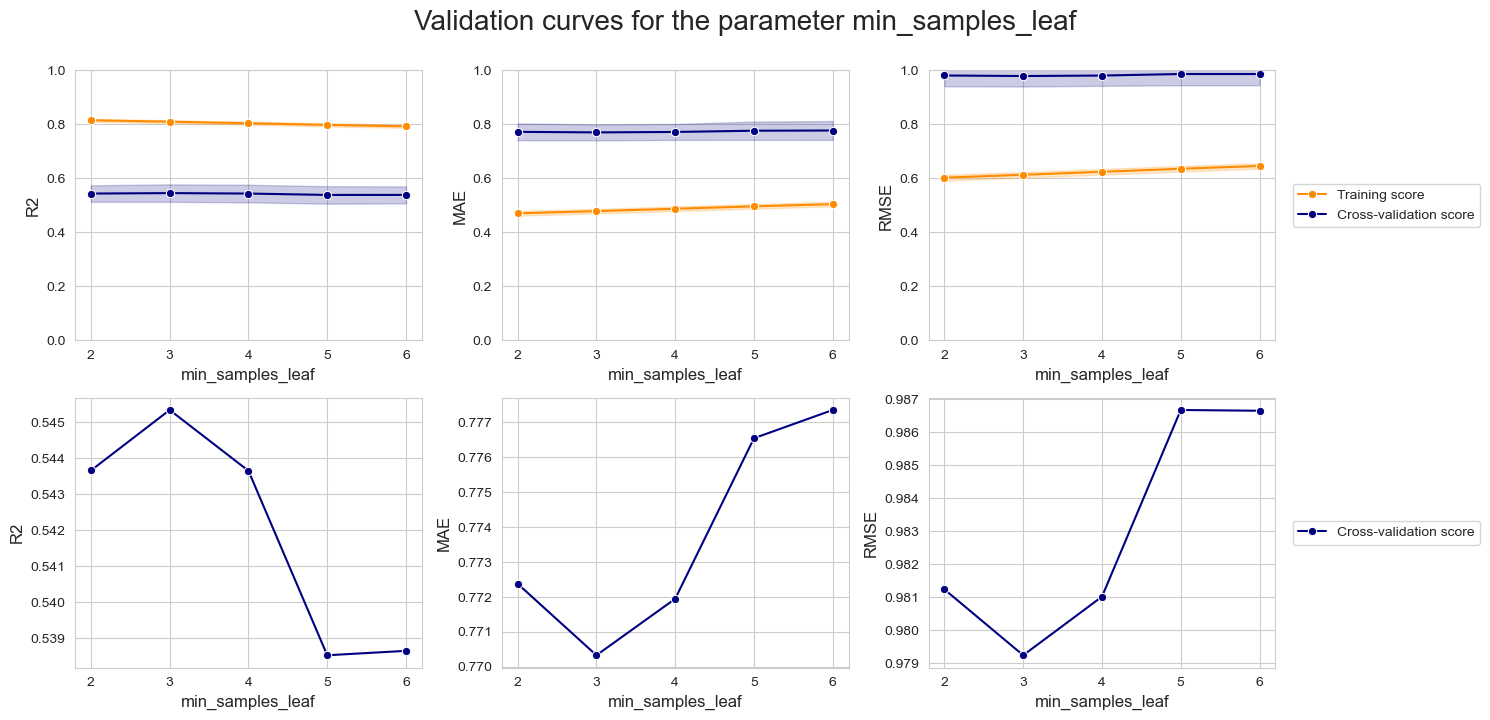

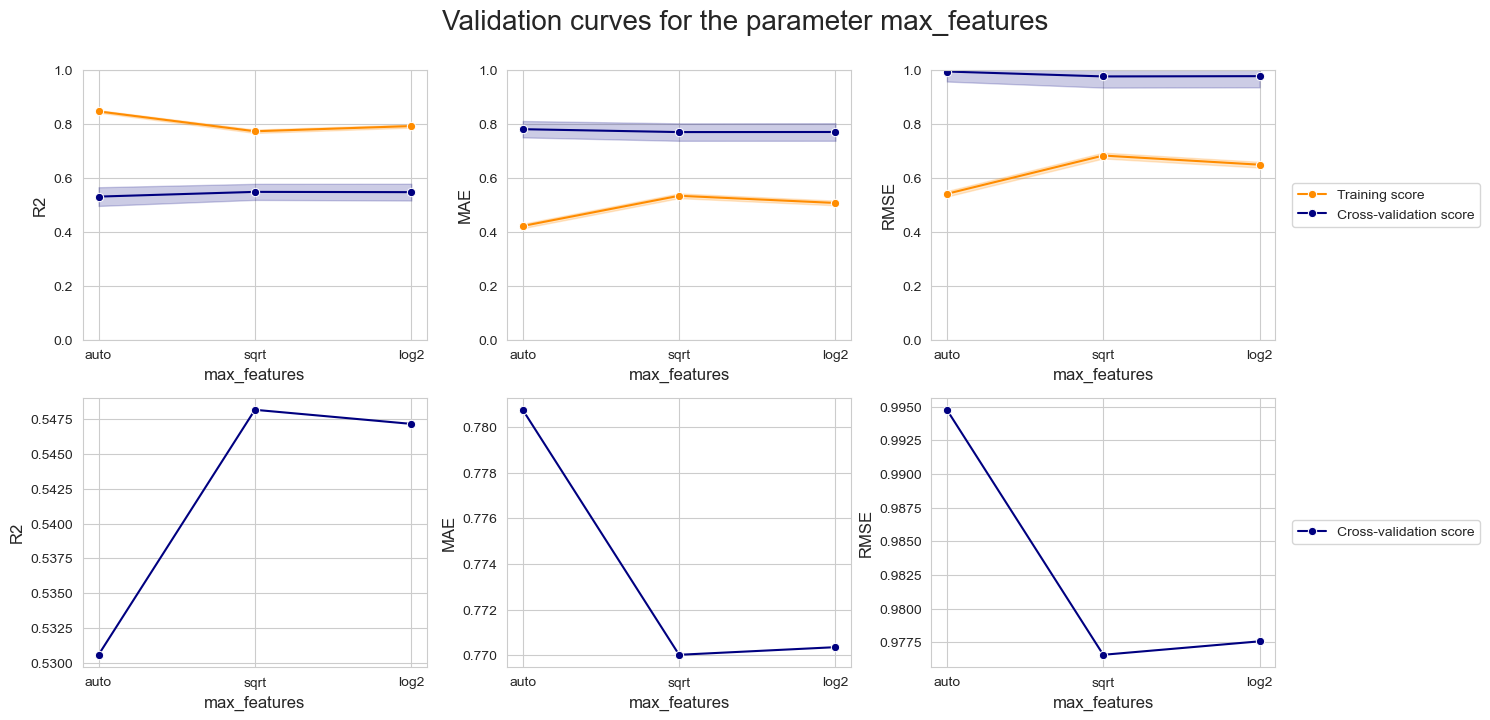

<IPython.core.display.Javascript object>

In [133]:
%%notify -m "Fitting done"

params_gb2 = {
    'model__n_estimators':[175, 200, 225, 250, 275, 300],
    'model__max_depth':[2, 3, 4, 5],
    'model__min_samples_split':[4, 6, 8, 10, 12],
    'model__min_samples_leaf':[2, 3, 4, 5, 6],
    'model__max_features':['auto', 'sqrt', 'log2']
            }

scores_test_gb2_opti, gs_results_gb2_opti, gs_gb2_opti = regressor(X, y_emi, GradientBoostingRegressor(), params_gb2)

## <a name='6.3'>6.3 XGBoost learning curves</a>

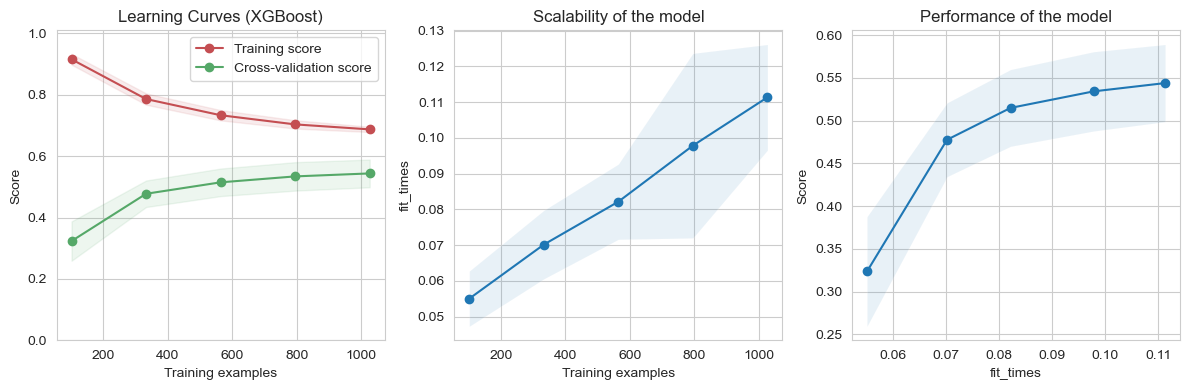

In [169]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))

title = "Learning Curves (XGBoost)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)


# Step 1 - Preprocessing numerical and categorical features

## 1.1 - KNN Imputation and standard scaling of numerical features
numeric_features = X.loc[:, X.columns != 'OSEBuildingID']\
                    .select_dtypes(exclude=['object','category'])\
                    .columns

numeric_transformer = Pipeline(steps=[
                                ('imputer', KNNImputer()),
                                ('scaler', StandardScaler())])

## 1.2 - One hot encoding of categorical features
categorical_features = X.loc[:, X.columns != 'OSEBuildingID']\
                        .select_dtypes(exclude=['int', 'float'])\
                        .columns

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

## 1.3 - ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y_emi, train_size=0.8, random_state=1)

model = GradientBoostingRegressor(max_depth=2,
                                  max_features='sqrt',
                                  min_samples_leaf=4,
                                  min_samples_split=6,
                                  n_estimators=250)


# Step 3 - Pipeline for preprocessor and model

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])


plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes[:], ylim=(0, 1.01), cv=cv, n_jobs=-1
)

plt.savefig('learning_curves_xgboost_emissions.png', transparent=True, bbox_inches='tight')
plt.show()

## <a name='6.4'>6.4 ENERGYSTARScore influence</a>

In [134]:
importance_gridsearch2 = gs_gb2_opti.best_estimator_.named_steps['model'].feature_importances_
attributes2 = list(X)
importance2 = pd.DataFrame(list(zip(attributes2, importance_gridsearch2)),
                                 columns =['Feature','Importance'])\
                      .sort_values('Importance', ascending=False)
#https://www.kaggle.com/code/raviolli77/random-forest-in-python/notebook
importance2

Feature  Importance
4              Latitude    0.307077
3          Neighborhood    0.178811
7     NumberofBuildings    0.067538
6             YearBuilt    0.052951
2   CouncilDistrictCode    0.039582
10  PropertyGFABuilding    0.027555
9      PropertyGFATotal    0.021600
0         OSEBuildingID    0.016902
12      ENERGYSTARScore    0.015717
1   PrimaryPropertyType    0.010351
13    TotalInnerSurface    0.009241
5             Longitude    0.008787
8        NumberofFloors    0.007592
11   PropertyGFAParking    0.002506

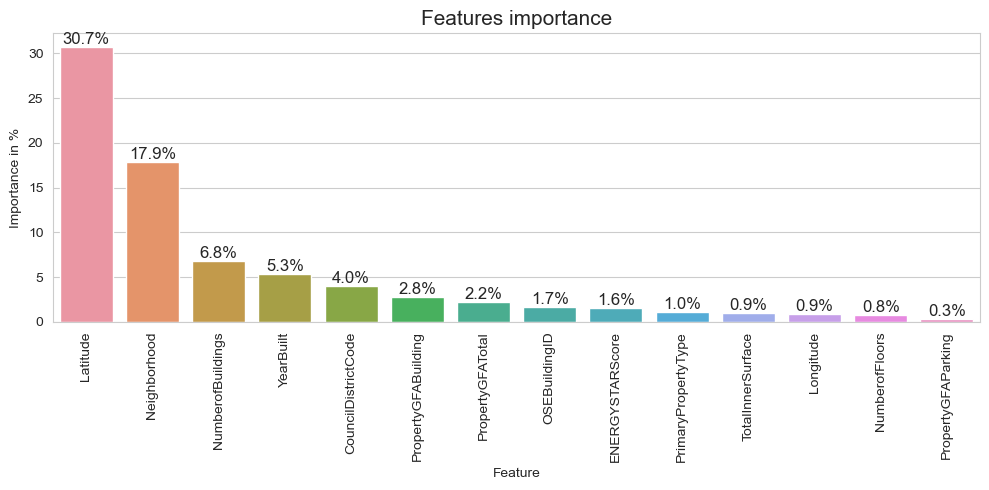

In [135]:
fig, ax = plt.subplots(figsize=(10, 5))

df_len = len(importance2.Feature)

sns.barplot(x=importance2.Feature, y=importance2.Importance*100)

container = ax.containers[0]
ax.bar_label(container,
             labels=[f'{x:.1f}%' for x in container.datavalues],
             label_type='edge',
             size=12)

plt.title('Features importance', fontsize=15)
plt.ylabel('Importance in %')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Features_importance_emissions.png', transparent=True, bbox_inches='tight')
plt.show()

<div class="alert alert-block alert-info">

Contribution of ENERGYSTARScore is not significant. It is therefore not worth measuring.
    
</div>